## Set up Dataset

In [122]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [123]:
import sys
sys.path.append('/home/sgf2/DBMI_server/drug_repo/molecule_ge_coordinated_embeddings/molecule_ge_coordinated_embeddings/')

import datasets as datasets
import models as models
import losses as losses
import utils
import config as cf
import torch

import pickle
import os

In [367]:
BASE_DIR = "../experiments/V3/drug_cell_split/757fec7c00aa9f62b42dcdfaaac3d958/"
MODEL_PATH = os.path.join(BASE_DIR, "checkpoint_757fec7c00aa9f62b42dcdfaaac3d958_val_mrr=0.03395276958079084.pth")

FIG_SAVE_PATH = "/home/sgf2/DBMI_server/drug_repo/molecule_ge_coordinated_embeddings/figures/drug_cell_split/"
NUMPY_RESULTS_PATH = '/home/sgf2/DBMI_server/drug_repo/molecule_ge_coordinated_embeddings/numpy/'

In [ ]:
config = cf.read_json(os.path.join(BASE_DIR, "experiment_config.json"))
config['exp_dir'] = os.path.join(config["trainer"]["base_exp_dir"], config["model_name"])

config['device_num'] = 4

torch.cuda.set_device(config['device_num'])

# Load Train Dataset
if "precomputed_train" in config['dataset']:
    train_dataset = pickle.load(open(config['dataset']["precomputed_train"], "rb"))
elif "save_train" in config['dataset']:
    train_dataset = pickle.load(open(config['dataset']["save_train"], "rb"))
else:
    train_dataset = cf.initialize_from_config(config, 'dataset', datasets)

# Force Test Set
val_dataset = cf.initialize_from_config(config, 'dataset', datasets, split="test")

train_loader = cf.initialize_from_config(config, 'data_loader', torch.utils.data, train_dataset, shuffle=False)
val_loader = cf.initialize_from_config(config, 'data_loader', torch.utils.data, val_dataset)

# Wrappers for embedding evaluation
ge_wrapper_train = cf.initialize_from_config(config, 'dataset_wrapper_ge', datasets, train_dataset)
ge_wrapper_val = cf.initialize_from_config(config, 'dataset_wrapper_ge', datasets, val_dataset)
smiles_wrapper_train = cf.initialize_from_config(config, 'dataset_wrapper_smiles', datasets, train_dataset)
smiles_wrapper_val = cf.initialize_from_config(config, 'dataset_wrapper_smiles', datasets, val_dataset)

uniq_train_perts = set(smiles_wrapper_train.pert_smiles)
uniq_val_perts = set(smiles_wrapper_val.pert_smiles)

ge_loader_train = cf.initialize_from_config(config, 'data_loader_singlet', torch.utils.data, ge_wrapper_train)
ge_loader_val = cf.initialize_from_config(config, 'data_loader_singlet', torch.utils.data, ge_wrapper_val)
smiles_loader_train = cf.initialize_from_config(config, 'data_loader_singlet', torch.utils.data, smiles_wrapper_train)
smiles_loader_val = cf.initialize_from_config(config, 'data_loader_singlet', torch.utils.data, smiles_wrapper_val)

smiles_to_feats = datasets.smiles_to_rdkit_feats(list(uniq_train_perts.union(uniq_val_perts)))

In [1]:
model = cf.initialize_from_config(config, 'model', models, n_feats_genes=train_dataset.n_feats_genes,
                                              smiles_to_feats=smiles_to_feats)
model.load_state_dict(torch.load(MODEL_PATH))

RDKit WARNING: [14:28:52] Enabling RDKit 2019.09.3 jupyter extensions


<All keys matched successfully>

In [2]:
train_dataset.cells_test

['HT29']

### Load Model

In [3]:
if 'rdkit_features' in config and config['rdkit_features']:
    chemprop_model_pretrained = models.load_chemprop_model("/home/sgf2/DBMI_server/drug_repo/chemprop/pcba/model_optimized.pt")
else:
    chemprop_model_pretrained = models.load_chemprop_model("/home/sgf2/DBMI_server/drug_repo/chemprop/pcba/model_unoptimized.pt")

In [4]:
import numpy as np

def get_embeddings(model, ge_wrapper, ge_loader, smiles_wrapper, smiles_loader):
    gex_raw = np.zeros([ge_wrapper.__len__(), ge_wrapper.__getitem__(0)[0].shape[0]])
    gex_embeddings = np.zeros([ge_wrapper.__len__(), model.embed_size])
    smiles_gex_labels = []
    smiles_chem_labels = []
    chem_embeddings = np.zeros([smiles_wrapper.__len__(), model.embed_size])
    
    if 'rdkit_features' in config and config['rdkit_features']:
        nfeats_chemprop = 2400
    else:
        nfeats_chemprop = 300
    chem_embeddings_chemprop = np.zeros([smiles_wrapper.__len__(), nfeats_chemprop])
    # smiles_strings = smiles_wrapper.pert_smiles

    model.eval()
    with torch.no_grad():
        # GE embeds for all of train
        for i, batch in enumerate(ge_loader):
            gex = batch[0].cuda()
            start_ind = i * ge_loader.batch_size
            end_ind = start_ind + gex.shape[0]

            smiles_gex_labels.extend(batch[1])
            gex_embeddings[start_ind:end_ind, :] = model.ge_embed(gex).cpu().numpy()
            gex_raw[start_ind:end_ind, :] = gex.cpu().numpy()

        # Embeds for all unique chems
        for i, batch in enumerate(smiles_loader):
            smiles = batch
            smiles_chem_labels.extend(batch)
            start_ind = i * smiles_loader.batch_size
            end_ind = start_ind + len(smiles)
            if 'rdkit_features' in config and config['rdkit_features']:
                feats = [smiles_to_feats[x] for x in smiles]
                chem_embeds = model.chem_linear(model.chemprop_encoder(smiles, feats))
                chem_embeds_chemprop = chemprop_model_pretrained(smiles, feats)
            else:
                chem_embeds = model.chem_linear(model.chemprop_encoder(smiles))
                chem_embeds_chemprop = chemprop_model_pretrained(smiles)
            chem_embeddings[start_ind:end_ind, :] = chem_embeds.cpu().numpy()
            chem_embeddings_chemprop[start_ind:end_ind, :] = chem_embeds_chemprop.cpu().numpy()
            
    # Embeddings for all chems in train
    smile_to_chem = {}
    smile_to_chem_cp = {}
    for i, smile in enumerate(smiles_chem_labels):
        smile_to_chem[smile] = chem_embeddings[i,:]
        smile_to_chem_cp[smile] = chem_embeddings_chemprop[i,:]

    chem_embeddings_all = []
    chem_embeddings_all_chemprop = []
    for smile in smiles_gex_labels:
        chem_embeddings_all.append(smile_to_chem[smile])
        chem_embeddings_all_chemprop.append(smile_to_chem_cp[smile])
    chem_embeddings_all = np.stack(chem_embeddings_all)
    chem_embeddings_all_chemprop = np.stack(chem_embeddings_all_chemprop)

    return (np.nan_to_num(gex_raw), np.nan_to_num(gex_embeddings),
            np.nan_to_num(chem_embeddings_all), np.nan_to_num(chem_embeddings),
            np.nan_to_num(chem_embeddings_all_chemprop), np.nan_to_num(chem_embeddings_chemprop),
            np.array(smiles_gex_labels), np.array(smiles_chem_labels))

In [5]:
gex_raw_train, gex_embeddings_train, chem_embeddings_train, chem_embeddings_unique_train, chem_embeddings_chemprop_train, chem_embeddings_unique_chemprop_train, smiles_gex_labels_train, smiles_chem_labels_train = get_embeddings(model, ge_wrapper_train, ge_loader_train, smiles_wrapper_train, smiles_loader_train)
gex_raw_train.shape, gex_embeddings_train.shape, chem_embeddings_train.shape, chem_embeddings_unique_train.shape , chem_embeddings_chemprop_train.shape, chem_embeddings_unique_chemprop_train.shape, len(smiles_gex_labels_train), len(smiles_chem_labels_train)

((97210, 2934),
 (97210, 51),
 (97210, 51),
 (3490, 51),
 (97210, 2400),
 (3490, 2400),
 97210,
 3490)

In [6]:
gex_raw, gex_embeddings, chem_embeddings, chem_embeddings_unique, chem_embeddings_chemprop, chem_embeddings_unique_chemprop, smiles_gex_labels, smiles_chem_labels = get_embeddings(model, ge_wrapper_val, ge_loader_val, smiles_wrapper_val, smiles_loader_val)
gex_raw.shape, gex_embeddings.shape, chem_embeddings.shape, chem_embeddings_unique.shape, chem_embeddings_chemprop.shape, chem_embeddings_unique_chemprop.shape, len(smiles_gex_labels), len(smiles_chem_labels)

((2317, 2934),
 (2317, 51),
 (2317, 51),
 (437, 51),
 (2317, 2400),
 (437, 2400),
 2317,
 437)

In [ ]:
# For the oracle
trainCelltestPert_dataset = cf.initialize_from_config(config, 'dataset', datasets, split="trainCell_testPert")

ge_wrapper_trainCelltestPert = cf.initialize_from_config(config, 'dataset_wrapper_ge', datasets, trainCelltestPert_dataset)
ge_loader_trainCelltestPert = cf.initialize_from_config(config, 'data_loader_singlet', torch.utils.data, ge_wrapper_trainCelltestPert)
smiles_wrapper_trainCelltestPert = cf.initialize_from_config(config, 'dataset_wrapper_smiles', datasets, trainCelltestPert_dataset)
smiles_loader_trainCelltestPert = cf.initialize_from_config(config, 'data_loader_singlet', torch.utils.data, smiles_wrapper_trainCelltestPert)

(gex_raw_trainCelltestPert, gex_embeddings_trainCelltestPert,
 _, _,
 _, _,
 smiles_gex_labels_trainCelltestPert, _) = get_embeddings(model, ge_wrapper_trainCelltestPert, ge_loader_trainCelltestPert,
                                                                    smiles_wrapper_trainCelltestPert, smiles_loader_trainCelltestPert)

gex_raw_trainCelltestPert.shape, gex_embeddings_trainCelltestPert.shape, len(smiles_gex_labels_trainCelltestPert)

#### Save minimum embeddings

np.savez(NUMPY_RESULTS_PATH + 'drug_cell_embeds.npz',
         gex_raw, gex_embeddings,
         chem_embeddings, chem_embeddings_unique,
         chem_embeddings_chemprop,
         chem_embeddings_unique_chemprop,
         smiles_gex_labels, smiles_chem_labels,
         gex_raw_train, gex_embeddings_train,
         chem_embeddings_train, chem_embeddings_unique_train,
         chem_embeddings_chemprop_train, chem_embeddings_unique_chemprop_train,
         smiles_gex_labels_train, smiles_chem_labels_train,
         gex_raw_trainCelltestPert, gex_embeddings_trainCelltestPert,
         smiles_gex_labels_trainCelltestPert
        )

#### Compute averaged embeddings

In [7]:
import pandas as pd
gex_embeddings_mean_pd = pd.DataFrame(data=gex_embeddings, index = smiles_gex_labels).rename_axis(index=['smiles']).groupby('smiles').mean()
chem_embeddings_mean_pd = pd.DataFrame(data=chem_embeddings_unique, index = smiles_chem_labels ).rename_axis(index=['smiles']).groupby('smiles').mean()
assert(all(gex_embeddings_mean_pd.index.values == chem_embeddings_mean_pd.index.values))

In [8]:
ge_embeddings_mean_train_pd = pd.DataFrame(data=gex_embeddings_train, index = smiles_gex_labels_train ).rename_axis(index=['smiles']).groupby('smiles').mean()
chem_embeddings_mean_train_pd = pd.DataFrame(data=chem_embeddings_unique_train, index = smiles_chem_labels_train ).rename_axis(index=['smiles']).groupby('smiles').mean()
chem_embeddings_mean_train_chemprop_pd = pd.DataFrame(data=chem_embeddings_unique_chemprop_train, index = smiles_chem_labels_train ).rename_axis(index=['smiles']).groupby('smiles').mean()
chem_embeddings_mean_chemprop_pd = pd.DataFrame(data=chem_embeddings_unique_chemprop, index = smiles_chem_labels ).rename_axis(index=['smiles']).groupby('smiles').mean()

In [421]:
gex_raw_mean_pd = pd.DataFrame(data=gex_raw[:,-978:], index = smiles_gex_labels).rename_axis(index=['smiles']).groupby('smiles').mean()
gex_raw_mean_train_pd = pd.DataFrame(data=gex_raw_train[:,-978:], index = smiles_gex_labels_train ).rename_axis(index=['smiles']).groupby('smiles').mean()

gex_raw_mean_wBaseline_pd = pd.DataFrame(data=gex_raw, index = smiles_gex_labels).rename_axis(index=['smiles']).groupby('smiles').mean()
gex_raw_mean_wBaseline_train_pd = pd.DataFrame(data=gex_raw_train, index = smiles_gex_labels_train ).rename_axis(index=['smiles']).groupby('smiles').mean()

In [422]:
gex_raw_mean_trainCelltestPert_pd = pd.DataFrame(data=gex_raw_trainCelltestPert[:,-978:], index = smiles_gex_labels_trainCelltestPert ).rename_axis(index=['smiles']).groupby('smiles').mean()
gex_raw_mean_wBaseline_trainCelltestPert_pd = pd.DataFrame(data=gex_raw_trainCelltestPert, index = smiles_gex_labels_trainCelltestPert ).rename_axis(index=['smiles']).groupby('smiles').mean()

In [129]:
gex_embeddings_mean_trainCelltestPert_pd = pd.DataFrame(gex_embeddings_trainCelltestPert, index = smiles_gex_labels_trainCelltestPert).rename_axis(index=['smiles']).groupby('smiles').mean()
assert np.min(gex_embeddings_mean_trainCelltestPert_pd.index == smiles_chem_labels)
gex_embeddings_mean_trainCelltestPert_pd.shape

## GE Embeddings Visualization

In [17]:
import umap
reducer = umap.UMAP()
umap_embed_ge_valfit = reducer.fit_transform(gex_embeddings_mean_pd)
umap_embed_ge_train = reducer.fit_transform(ge_embeddings_mean_train_pd)

train_test_stack_labels_ge = [0]*ge_embeddings_mean_train_pd.shape[0] + [1]*gex_embeddings_mean_pd.shape[0]
train_test_stack_ge = np.vstack([ge_embeddings_mean_train_pd, gex_embeddings_mean_pd])
umap_embed_ge_all = reducer.fit_transform(train_test_stack_ge)
umap_embed_ge_fitall = reducer.fit(train_test_stack_ge).transform(gex_embeddings_mean_pd)
umap_embed_ge_fitall_train = reducer.fit(train_test_stack_ge).transform(ge_embeddings_mean_train_pd)

In [714]:
umap_raw_ge_valfit = reducer.fit_transform(gex_raw_mean_pd)
umap_raw_ge_train = reducer.fit_transform(gex_raw_mean_train_pd)

train_test_stack_ge_raw = np.vstack([gex_raw_mean_train_pd, gex_raw_mean_pd])
umap_raw_ge_all = reducer.fit_transform(train_test_stack_ge_raw)
umap_raw_ge_fitall = reducer.fit(train_test_stack_ge_raw).transform(gex_raw_mean_pd)

In [708]:
umap_raw_ge_fitall_train = reducer.fit(train_test_stack_ge_raw).transform(gex_raw_mean_train_pd)

In [700]:
from scipy import stats
smiles_to_cellIDs = ge_loader_train.dataset.lincs_dataset.l1000_perts.groupby("canonical_smiles").agg(lambda x: stats.mode(x.index.get_level_values("cell_id"))[0] ).iloc[:,0]
np.min(smiles_chem_labels_train == smiles_to_cellIDs.index.values)

smiles_to_cellIDs.value_counts()

PC3     1114
MCF7     957
A375     798
VCAP     617
HA1E       4
Name: (16, AARS), dtype: int64

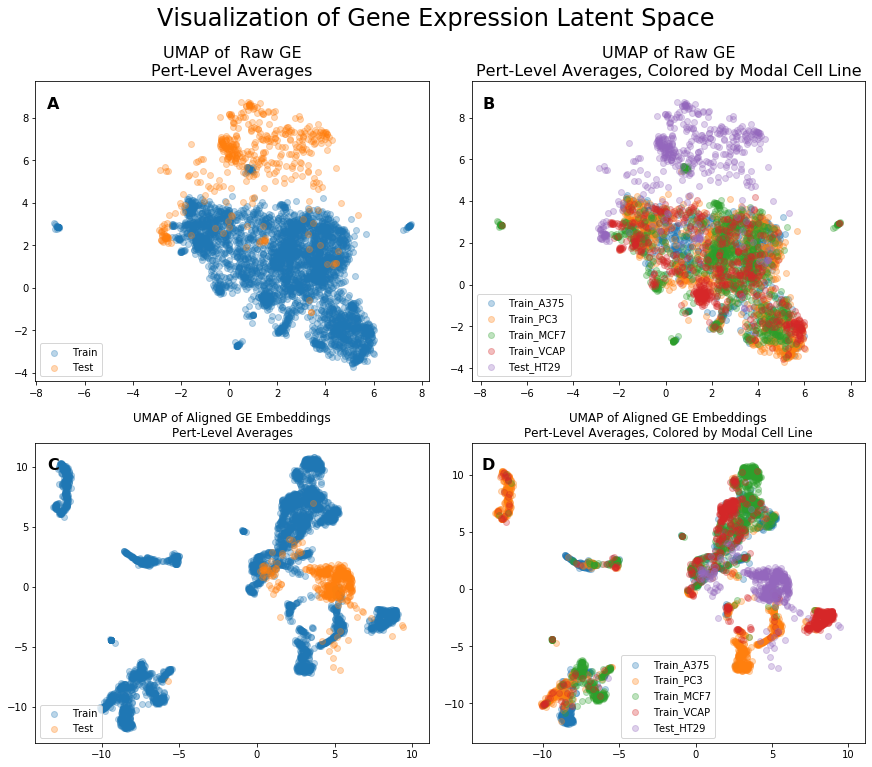

In [763]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(ncols=2, nrows=2, sharey=False, sharex=False, constrained_layout=True)

label_offsetx = 0.06
label_offsety = 0.95
title_size = 16

ax1.scatter(umap_raw_ge_fitall_train[:, 0],
            umap_raw_ge_fitall_train[:, 1], label="Train", alpha=alpha)

ax1.scatter(umap_raw_ge_fitall[:, 0], umap_raw_ge_fitall[:, 1], label="Test", alpha=alpha)
ax1.set(title = 'UMAP of  Raw GE\nPert-Level Averages');
ax1.title.set_size(title_size)
ax1.legend(loc=3)


inds_train_a375 = np.where(smiles_to_cellIDs.values == "A375")
ax2.scatter(umap_raw_ge_fitall_train[inds_train_a375, 0],
            umap_raw_ge_fitall_train[inds_train_a375, 1], label="Train_A375", alpha=alpha)

inds_train_PC3 = np.where(smiles_to_cellIDs.values == "PC3")
ax2.scatter(umap_raw_ge_fitall_train[inds_train_PC3, 0],
            umap_raw_ge_fitall_train[inds_train_PC3, 1], label="Train_PC3", alpha=alpha)

inds_train_MCF7 = np.where(smiles_to_cellIDs.values == "MCF7")
ax2.scatter(umap_raw_ge_fitall_train[inds_train_MCF7, 0],
            umap_raw_ge_fitall_train[inds_train_MCF7, 1], label="Train_MCF7", alpha=alpha)

inds_train_VCAP = np.where(smiles_to_cellIDs.values == "VCAP")
ax2.scatter(umap_raw_ge_fitall_train[inds_train_VCAP, 0],
            umap_raw_ge_fitall_train[inds_train_VCAP, 1], label="Train_VCAP", alpha=alpha)
ax2.scatter(umap_raw_ge_fitall[:, 0], umap_raw_ge_fitall[:, 1], label="Test_HT29", alpha=alpha)
ax2.set(title = 'UMAP of Raw GE\nPert-Level Averages, Colored by Modal Cell Line')
ax2.title.set_size(title_size)
ax2.legend(loc=3)



ax3.scatter(umap_embed_ge_fitall_train[:, 0],
            umap_embed_ge_fitall_train[:, 1], label="Train", alpha=alpha)

ax3.scatter(umap_embed_ge_fitall[:, 0], umap_embed_ge_fitall[:, 1], label="Test", alpha=alpha)
ax3.set(title = 'UMAP of Aligned GE Embeddings\nPert-Level Averages')
ax3.legend(loc=3)



inds_train_a375 = np.where(smiles_to_cellIDs.values == "A375")
ax4.scatter(umap_embed_ge_fitall_train[inds_train_a375, 0],
            umap_embed_ge_fitall_train[inds_train_a375, 1], label="Train_A375", alpha=alpha)

inds_train_PC3 = np.where(smiles_to_cellIDs.values == "PC3")
ax4.scatter(umap_embed_ge_fitall_train[inds_train_PC3, 0],
            umap_embed_ge_fitall_train[inds_train_PC3, 1], label="Train_PC3", alpha=alpha)

inds_train_MCF7 = np.where(smiles_to_cellIDs.values == "MCF7")
ax4.scatter(umap_embed_ge_fitall_train[inds_train_MCF7, 0],
            umap_embed_ge_fitall_train[inds_train_MCF7, 1], label="Train_MCF7", alpha=alpha)

inds_train_VCAP = np.where(smiles_to_cellIDs.values == "VCAP")
ax4.scatter(umap_embed_ge_fitall_train[inds_train_VCAP, 0],
            umap_embed_ge_fitall_train[inds_train_VCAP, 1], label="Train_VCAP", alpha=alpha)
ax4.scatter(umap_embed_ge_fitall[:, 0], umap_embed_ge_fitall[:, 1], label="Test_HT29", alpha=alpha)
ax4.set(title = 'UMAP of Aligned GE Embeddings\nPert-Level Averages, Colored by Modal Cell Line')
ax4.legend()


ax1.text(label_offsetx, label_offsety, "A", transform=ax1.transAxes,
      fontsize=16, fontweight='bold', va='top', ha='right')
ax2.text(label_offsetx, label_offsety, "B", transform=ax2.transAxes,
      fontsize=16, fontweight='bold', va='top', ha='right')
ax3.text(label_offsetx, label_offsety, "C", transform=ax3.transAxes,
      fontsize=16, fontweight='bold', va='top', ha='right')
ax4.text(label_offsetx, label_offsety, "D", transform=ax4.transAxes,
      fontsize=16, fontweight='bold', va='top', ha='right')

fig.set_figwidth(12)
fig.set_figheight(10)
fig.suptitle("Visualization of Gene Expression Latent Space", fontsize=24, y = 1.05)

plt.savefig(FIG_SAVE_PATH + 'ge_big_latent_viz.png', bbox_inches='tight')
plt.savefig(FIG_SAVE_PATH + 'ge_big_latent_viz.pdf', bbox_inches='tight')

plt.show()

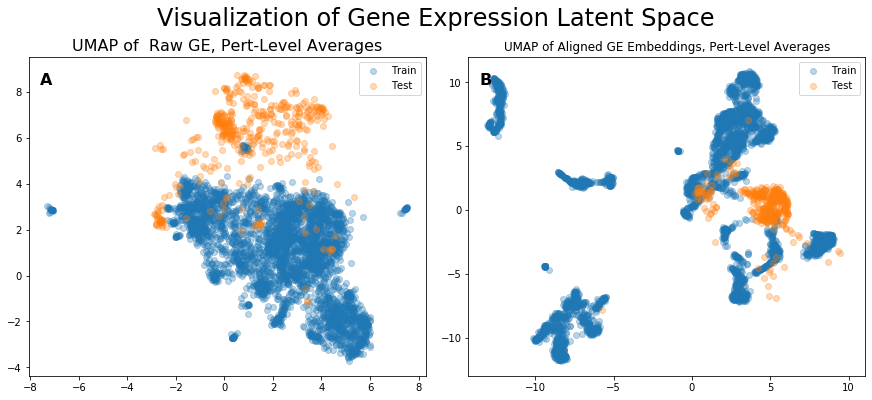

In [764]:
fig, (ax1, ax2) = plt.subplots(ncols=2, nrows=1, sharey=False, sharex=False, constrained_layout=True)

label_offsetx = 0.06
label_offsety = 0.95
title_size = 16

ax1.scatter(umap_raw_ge_fitall_train[:, 0],
            umap_raw_ge_fitall_train[:, 1], label="Train", alpha=alpha)

ax1.scatter(umap_raw_ge_fitall[:, 0], umap_raw_ge_fitall[:, 1], label="Test", alpha=alpha)
ax1.set(title = 'UMAP of  Raw GE, Pert-Level Averages');
ax1.title.set_size(title_size)
ax1.legend()


ax2.scatter(umap_embed_ge_fitall_train[:, 0],
            umap_embed_ge_fitall_train[:, 1], label="Train", alpha=alpha)

ax2.scatter(umap_embed_ge_fitall[:, 0], umap_embed_ge_fitall[:, 1], label="Test", alpha=alpha)
ax2.set(title = 'UMAP of Aligned GE Embeddings, Pert-Level Averages')
ax2.legend()


ax1.text(label_offsetx, label_offsety, "A", transform=ax1.transAxes,
      fontsize=16, fontweight='bold', va='top', ha='right')
ax2.text(label_offsetx, label_offsety, "B", transform=ax2.transAxes,
      fontsize=16, fontweight='bold', va='top', ha='right')


fig.set_figwidth(12)
fig.set_figheight(5)
fig.suptitle("Visualization of Gene Expression Latent Space", fontsize=24, y = 1.08)

plt.savefig(FIG_SAVE_PATH + 'ge_latent_trainTest.png', bbox_inches='tight')
plt.savefig(FIG_SAVE_PATH + 'ge_latent_trainTest.pdf', bbox_inches='tight')

plt.show()

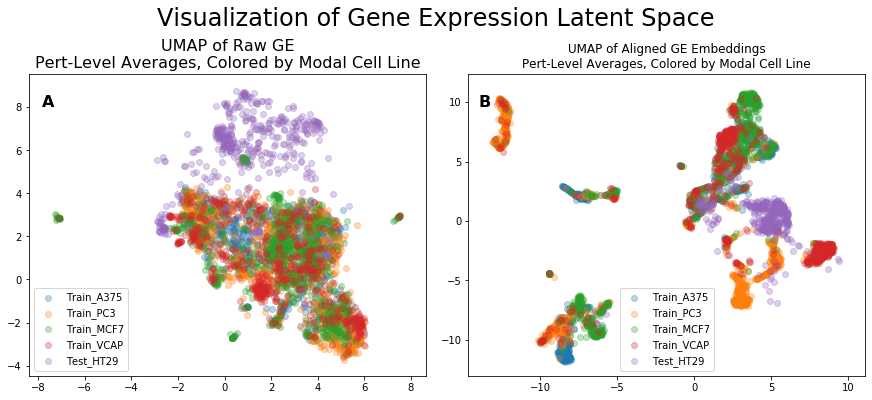

In [765]:
fig, (ax1, ax2) = plt.subplots(ncols=2, nrows=1, sharey=False, sharex=False, constrained_layout=True)


inds_train_a375 = np.where(smiles_to_cellIDs.values == "A375")
ax1.scatter(umap_raw_ge_fitall_train[inds_train_a375, 0],
            umap_raw_ge_fitall_train[inds_train_a375, 1], label="Train_A375", alpha=alpha)

inds_train_PC3 = np.where(smiles_to_cellIDs.values == "PC3")
ax1.scatter(umap_raw_ge_fitall_train[inds_train_PC3, 0],
            umap_raw_ge_fitall_train[inds_train_PC3, 1], label="Train_PC3", alpha=alpha)

inds_train_MCF7 = np.where(smiles_to_cellIDs.values == "MCF7")
ax1.scatter(umap_raw_ge_fitall_train[inds_train_MCF7, 0],
            umap_raw_ge_fitall_train[inds_train_MCF7, 1], label="Train_MCF7", alpha=alpha)

inds_train_VCAP = np.where(smiles_to_cellIDs.values == "VCAP")
ax1.scatter(umap_raw_ge_fitall_train[inds_train_VCAP, 0],
            umap_raw_ge_fitall_train[inds_train_VCAP, 1], label="Train_VCAP", alpha=alpha)
ax1.scatter(umap_raw_ge_fitall[:, 0], umap_raw_ge_fitall[:, 1], label="Test_HT29", alpha=alpha)
ax1.set(title = 'UMAP of Raw GE\nPert-Level Averages, Colored by Modal Cell Line')
ax1.title.set_size(title_size)
ax1.legend(loc=3)

inds_train_a375 = np.where(smiles_to_cellIDs.values == "A375")
ax2.scatter(umap_embed_ge_fitall_train[inds_train_a375, 0],
            umap_embed_ge_fitall_train[inds_train_a375, 1], label="Train_A375", alpha=alpha)

inds_train_PC3 = np.where(smiles_to_cellIDs.values == "PC3")
ax2.scatter(umap_embed_ge_fitall_train[inds_train_PC3, 0],
            umap_embed_ge_fitall_train[inds_train_PC3, 1], label="Train_PC3", alpha=alpha)

inds_train_MCF7 = np.where(smiles_to_cellIDs.values == "MCF7")
ax2.scatter(umap_embed_ge_fitall_train[inds_train_MCF7, 0],
            umap_embed_ge_fitall_train[inds_train_MCF7, 1], label="Train_MCF7", alpha=alpha)

inds_train_VCAP = np.where(smiles_to_cellIDs.values == "VCAP")
ax2.scatter(umap_embed_ge_fitall_train[inds_train_VCAP, 0],
            umap_embed_ge_fitall_train[inds_train_VCAP, 1], label="Train_VCAP", alpha=alpha)
ax2.scatter(umap_embed_ge_fitall[:, 0], umap_embed_ge_fitall[:, 1], label="Test_HT29", alpha=alpha)
ax2.set(title = 'UMAP of Aligned GE Embeddings\nPert-Level Averages, Colored by Modal Cell Line')
ax2.legend()

ax1.text(label_offsetx, label_offsety, "A", transform=ax3.transAxes,
      fontsize=16, fontweight='bold', va='top', ha='right')
ax2.text(label_offsetx, label_offsety, "B", transform=ax4.transAxes,
      fontsize=16, fontweight='bold', va='top', ha='right')

fig.set_figwidth(12)
fig.set_figheight(5)
fig.suptitle("Visualization of Gene Expression Latent Space", fontsize=24, y = 1.08)

plt.savefig(FIG_SAVE_PATH + 'ge_latent_cellLine.png', bbox_inches='tight')
plt.savefig(FIG_SAVE_PATH + 'ge_latent_cellLine.pdf', bbox_inches='tight')

plt.show()

## Chem Embeddings Visualization

In [10]:
import umap
import matplotlib.pyplot as plt
import seaborn as sns
reducer = umap.UMAP()
umap_embed_chem_valfit = reducer.fit_transform(chem_embeddings_mean_pd)
umap_embed_chem_train = reducer.fit_transform(chem_embeddings_mean_train_pd)

train_test_stack = np.vstack([chem_embeddings_mean_train_pd, chem_embeddings_mean_pd])
train_test_stack_labels = [0]*chem_embeddings_mean_train_pd.shape[0] + [1]*chem_embeddings_mean_pd.shape[0]
umap_embed_chem_all = reducer.fit_transform(train_test_stack)
umap_embed_chem_fitall = reducer.fit(train_test_stack).transform(chem_embeddings_mean_pd)

umap_embed_chemprop_valfit = reducer.fit_transform(chem_embeddings_mean_chemprop_pd)
train_test_stack_cp = np.vstack([chem_embeddings_mean_train_chemprop_pd, chem_embeddings_mean_chemprop_pd])
umap_embed_chemprop_all = reducer.fit_transform(train_test_stack_cp)
umap_embed_chemprop_fitall = reducer.fit(train_test_stack_cp).transform(chem_embeddings_mean_chemprop_pd)


## Moleculenet Info

In [25]:
moa = pd.read_hdf("/home/sgf2/DBMI_server/drug_repo/data/moleculenetTasks/MOA.hdf")

all_smiles = np.append(val_dataset.l1000_perts.index.get_level_values("canonical_smiles").values,
                                     train_dataset.l1000_perts.index.get_level_values("canonical_smiles").values)
all_pertids = np.append(val_dataset.l1000_perts.index.get_level_values("pert_id").values,
                                     train_dataset.l1000_perts.index.get_level_values("pert_id").values)

smiles_to_perts = dict(zip(all_smiles, all_pertids))

In [26]:
pertids_chem_labels = [smiles_to_perts[smile] for smile in smiles_chem_labels]
moa_val = moa.loc[pertids_chem_labels].set_index(smiles_chem_labels)
moa_val.sum(axis = 0).sort_values(ascending = False).head(16)

Serotonin receptor antagonist        9.0
Glutamate receptor antagonist        7.0
Cyclooxygenase inhibitor             6.0
Dopamine receptor agonist            6.0
EGFR inhibitor                       5.0
Acetylcholine receptor antagonist    5.0
Phosphodiesterase inhibitor          5.0
Serotonin receptor agonist           5.0
Adrenergic receptor agonist          5.0
Dopamine receptor antagonist         4.0
Adrenergic receptor antagonist       4.0
Retinoid receptor agonist            3.0
Tubulin inhibitor                    3.0
p38 MAPK inhibitor                   3.0
NFkB pathway inhibitor               3.0
PI3K inhibitor                       3.0
dtype: float64

In [27]:
pertids_chem_labels_train = [smiles_to_perts[smile] for smile in smiles_chem_labels_train]
moa_train = moa.loc[pertids_chem_labels_train].set_index(smiles_chem_labels_train)
moa_train.sum(axis = 0).sort_values(ascending = False).head()

Serotonin receptor antagonist      54.0
Dopamine receptor antagonist       52.0
Adrenergic receptor antagonist     48.0
Glucocorticoid receptor agonist    40.0
Cyclooxygenase inhibitor           40.0
dtype: float64

In [28]:
smiles_chem_labels_train_all = np.array(list(smiles_chem_labels_train) + list(smiles_chem_labels))
pertids_chem_labels_all = [smiles_to_perts[smile] for smile in smiles_chem_labels_train_all]
moa_all = moa.loc[pertids_chem_labels_all].set_index(smiles_chem_labels_train_all)

In [289]:
def moa_plots(umap_embed_chem = umap_embed_chem_fitall,
                 moa = moa_val,
                 title_label = 'test, fit all',
               ax = ax):
    def plot_moa(moa_str):
        inds_moa = moa[moa_str].values.nonzero()[0]
        sns.scatterplot(x=umap_embed_chem[inds_moa, 0], y=umap_embed_chem[inds_moa, 1],
                        s=80, label = moa_str,  legend=False, ax = ax)

    sns.scatterplot(x=umap_embed_chem[:, 0], y=umap_embed_chem[:, 1], s=25, legend=False, ax = ax)
    plt.gca().set_aspect('equal', 'datalim')

    plot_moa('Serotonin receptor antagonist')
    plot_moa("Glutamate receptor antagonist")
    plot_moa("Cyclooxygenase inhibitor")

    ax.title.set_text(title_label);

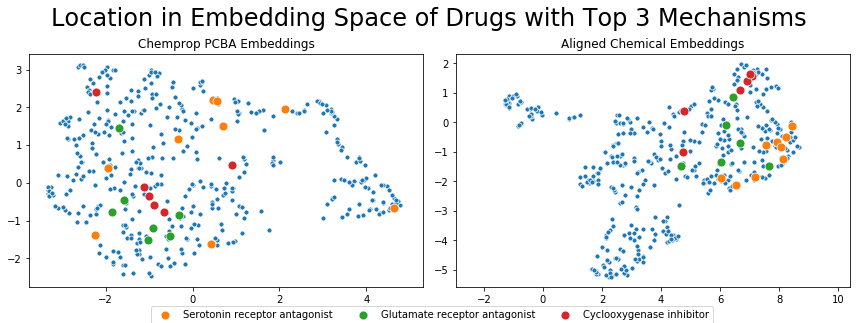

In [377]:
fig, (ax1, ax2) = plt.subplots(ncols=2)

moa_plots(umap_embed_chem = umap_embed_chemprop_valfit, title_label = 'Chemprop PCBA Embeddings', ax=ax1)
moa_plots(umap_embed_chem = umap_embed_chem_valfit, title_label = 'Aligned Chemical Embeddings', ax=ax2)

fig.set_figwidth(12)
fig.suptitle("Location in Embedding Space of Drugs with Top 3 Mechanisms", fontsize=24, y = 1.07)
handles, labels = ax2.get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center', bbox_to_anchor=(0.5,-0.02), ncol = 3)
plt.tight_layout()

plt.savefig(FIG_SAVE_PATH + 'umap_drugs_w_moa.png', bbox_inches='tight')
plt.savefig(FIG_SAVE_PATH + 'umap_drugs_w_moa.pdf', bbox_inches='tight')
plt.show()

# Training Set Similarity

In [33]:
from scipy.spatial.distance import cdist

In [34]:
gex_embeddings.shape, gex_embeddings_train.shape

((2317, 51), (97210, 51))

In [35]:
### Distance in chem space to nearest neighbor in train (per model) -- most relevant to drug split
dists_to_train_chem_embed = cdist(chem_embeddings_unique, chem_embeddings_unique_train,  metric='correlation')

dists_to_train_chem_embed[np.isnan(dists_to_train_chem_embed)] = 1
min_dists_to_train_chem_embed = dists_to_train_chem_embed.min(axis=1)
min_dists_to_train_chem_embed.shape

(437,)

In [36]:
### Distance in chem space to nearest neighbor in train (per model) -- most relevant to drug split
dists_to_train_chemprop = cdist(chem_embeddings_unique_chemprop, chem_embeddings_unique_chemprop_train,  metric='correlation')
min_dists_to_train_chemprop = dists_to_train_chemprop.min(axis=1)
min_dists_to_train_chemprop.shape

(437,)

In [37]:
### Distance in chem space to nearest neighbor in train (per fps) -- most relevant to drug split
from rdkit import DataStructs
from rdkit.Chem.Fingerprints import FingerprintMols
from rdkit.Chem import MolFromSmiles,AllChem

ms = [MolFromSmiles(x) for x in smiles_gex_labels]
fingerprints = np.stack([AllChem.GetMorganFingerprintAsBitVect(x,radius=2, nBits=512) for x in ms])

ms = [MolFromSmiles(x) for x in smiles_chem_labels]
fingerprints_unique = np.stack([AllChem.GetMorganFingerprintAsBitVect(x,radius=2, nBits=512) for x in ms])

ms_train = [MolFromSmiles(x) for x in smiles_gex_labels_train]
fingerprints_train = np.stack([AllChem.GetMorganFingerprintAsBitVect(x,radius=2, nBits=512) for x in ms_train])

ms_train = [MolFromSmiles(x) for x in smiles_chem_labels_train]
fingerprints_unique_train = np.stack([AllChem.GetMorganFingerprintAsBitVect(x,radius=2, nBits=512) for x in ms_train])

dists_to_train_fps = cdist(fingerprints_unique, fingerprints_unique_train,  metric='jaccard')
min_dists_to_train_fps = dists_to_train_fps.min(axis=1)

In [38]:
### Distance in ge space to nearest neighbor in train (per model) -- most relevant to CL split
### Distance in chem space to nearest neighbor in train (per model) -- most relevant to drug split
dists_to_train_ge_embed = cdist(gex_embeddings, gex_embeddings_train,  metric='correlation')
min_dists_to_train_ge_embed = dists_to_train_ge_embed.min(axis=1)
min_dists_to_train_ge_embed.shape

(2317,)

In [39]:
### Distance in ge space to nearest neighbor in train (per raw GE) -- most relevant to CL split
dists_to_train_ge_raw = cdist(gex_raw[:,-978:], gex_raw_train[:,-978:],  metric='correlation')
min_dists_to_train_ge_raw = dists_to_train_ge_raw.min(axis=1)
min_dists_to_train_ge_raw.shape

(2317,)

## Examples of molecules from train/test with zero distance in chemical fingerprints

In [40]:
inds_zero_dists = np.where(dists_to_train_fps == 0)
inds_zero_dists = list(zip(inds_zero_dists[0], inds_zero_dists[1]))

In [41]:
print("N molecules w/ mol with same fingerprint in train: ", len(set(np.where(dists_to_train_fps == 0)[0])))

N molecules w/ mol with same fingerprint in train:  64


In [42]:
first_repeated_ind = inds_zero_dists[0][0]
repeat_mol_inds_in_train = np.where(dists_to_train_fps == 0)[1][np.where(np.where(dists_to_train_fps == 0)[0] == first_repeated_ind)]
repeat_mol_inds_in_train

array([ 67, 101, 103])

In [380]:
 smiles_chem_labels[inds_zero_dists[0][0]]

'CC(=CC=CC(=CC(=O)O)C)C=CC1=C(C)CCCC1(C)C'

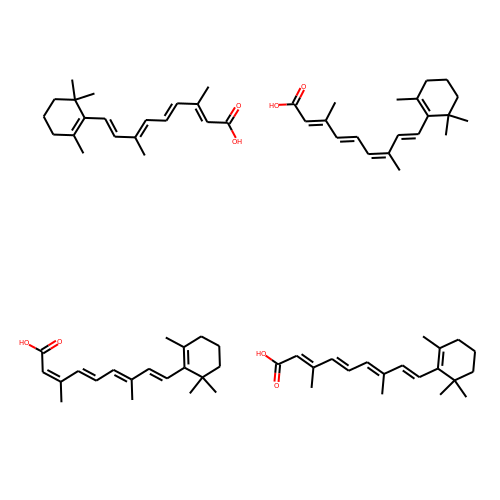

In [384]:
from rdkit.Chem import Draw
mol_list = [ms[inds_zero_dists[0][0]]] + [ms_train[x] for x in repeat_mol_inds_in_train]
img = Draw.MolsToGridImage(mol_list, molsPerRow=2, subImgSize=(250, 250))
img.save(FIG_SAVE_PATH + 'mols_w_fp_in_train_4.png', "PNG")
img.save(FIG_SAVE_PATH + 'mols_w_fp_in_train_4.pdf', "PDF")
img

In [372]:
img

PIL.PngImagePlugin.PngImageFile

In [44]:
from collections import Counter
most_common_ind_test = Counter(np.where(dists_to_train_fps == 0)[0]).most_common()[0][0]
most_common_mol_inds_in_train = np.where(dists_to_train_fps == 0)[1][np.where(np.where(dists_to_train_fps == 0)[0] == most_common_ind_test)]

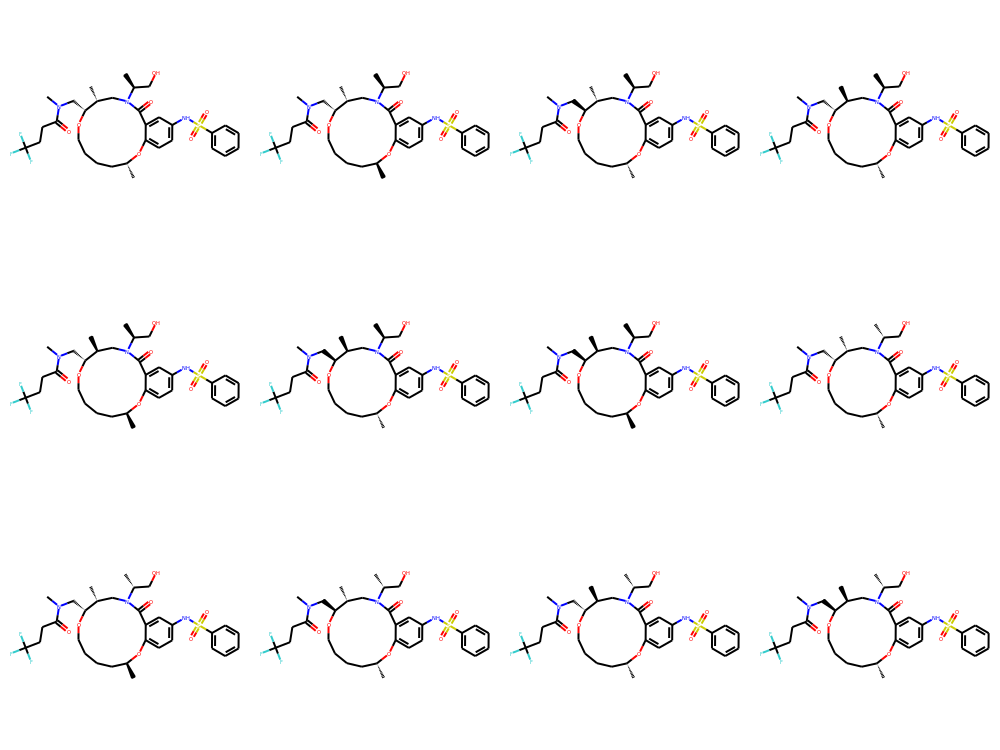

In [383]:
from rdkit.Chem import Draw
mol_list = [ms[most_common_ind_test]] + [ms_train[x] for x in most_common_mol_inds_in_train[0:11]]
img = Draw.MolsToGridImage(mol_list, molsPerRow=4, subImgSize=(250, 250))
img.save(FIG_SAVE_PATH + 'mols_w_fp_in_train_12.png', "PNG")
img.save(FIG_SAVE_PATH + 'mols_w_fp_in_train_12.pdf', "PDF")
img

## Ranking results

In [66]:
from scipy.stats.mstats import rankdata
import seaborn as sns

def get_ranks_first_match(gex_chem_ranks, smiles_gex_labels, smiles_chem_labels):
    rank_first_match = []
    for i, sml in enumerate(smiles_gex_labels):
        matches = np.where(smiles_chem_labels == sml)[0]
        ranks_matches = gex_chem_ranks[i, matches]
        rank_first_match.append(np.min(ranks_matches))
    rank_first_match = np.array(rank_first_match).squeeze()
    return rank_first_match

def prepare_metrics(rank_first_match, indices):
    median_rank = np.median(rank_first_match[indices])
    mrr = np.mean(1 / rank_first_match[indices])
    hits_at_10 = np.mean(
        [np.sum(results <= 10) for results in rank_first_match[indices]])  # can change to rank_all_matches
    hits_at_100 = np.mean([np.sum(results <= 100) for results in rank_first_match[indices]])
    hits_at_500 = np.mean([np.sum(results <= 500) for results in rank_first_match[indices]])
    return {#"total_drugs": len(set(np.array(smiles_gex_labels)[inds])),
            "median_rank": median_rank,
            "MRR": mrr,
            "H@10": hits_at_10,
            "H@100": hits_at_100,
            "H@500": hits_at_500
        }

def compute_grouped_embeddings(embeddings, labels):
    embeds_to_avg = pd.DataFrame(embeddings, index = labels)
    embeds_to_avg.index.name = "canonical_smiles"
    embeds_to_avg = embeds_to_avg.groupby('canonical_smiles').mean()
    embeddings_avg = embeds_to_avg.values
    smiles_labels_avg = embeds_to_avg.index.values
    return embeddings_avg, smiles_labels_avg

def get_val_scores(distmat,
                   smiles_gex_labels=smiles_gex_labels,
                   smiles_chem_labels=smiles_chem_labels,
                   train_smiles = list(set(smiles_chem_labels_train))):

    gex_chem_ranks = rankdata(distmat, axis=1)

    rank_first_match = get_ranks_first_match(gex_chem_ranks, smiles_gex_labels, smiles_chem_labels)

    list_of_inds = [[i for i,j in enumerate(smiles_gex_labels)]]
    
    ir_results = []
    for inds in list_of_inds:
        ir_results.append(prepare_metrics(rank_first_match, inds))

#    val_print_labels = ["Val (All):              "]
    val_print_labels = ['']
    for i, res_dict in enumerate(ir_results):
        print(val_print_labels[i] + "    ".join(['{}: {:.3f}'.format(k, res_dict[k]) for k in res_dict]))

    #match_dists = []
    #nonmatch_dists = []
    #for i, sml in enumerate(smiles_gex_labels):
    #    match = np.where(smiles_chem_labels == sml)[0]
    #    match_dists.append(distmat[i,match[0]])
    #    nonmatch_dists.extend( list(distmat[i,:match[0]]) + list(distmat[i,match[0]+1:]) )
    #match_sims = 1-np.array(match_dists)
    #nonmatch_sims = 1-np.array(nonmatch_dists)
    
    #print("Average correlation between matched GE and Chem embeds (CCA):   ", np.mean(match_sims))
    #print("Average correlation between unmatched GE and Chem embeds (CCA): ", np.mean(nonmatch_sims))
    #print("Difference: ", np.mean(match_sims) - np.mean(nonmatch_sims) )
    #print("Percentage diff: ", (100 * (np.mean(match_sims) - np.mean(nonmatch_sims)) / np.abs(np.mean(match_sims))) )
    #print()
    
    #sns.distplot(match_sims)
    #sns.distplot(nonmatch_sims)
        
    return rank_first_match

from sklearn.cross_decomposition import CCA
import time

def cca_cor(ncomp = 50,
            embeds_ge_train=gex_embeddings_train, embeds_ge_val=gex_embeddings,
            embeds_chem_train=chem_embeddings_train, embeds_chem_val=chem_embeddings,
            embeds_chem_uniq_val=chem_embeddings_unique
           ):


    start = time.time()

    print("CCA w/", ncomp, "components")
    cca = CCA(n_components=ncomp, max_iter = 1000)
    cca.fit(embeds_ge_train, embeds_chem_train)
    cca_gex_val, cca_chem_val = cca.transform(embeds_ge_val, embeds_chem_uniq_val)
    
    end = time.time()

    hours, rem = divmod(end-start, 3600)
    minutes, seconds = divmod(rem, 60)
    print("{:0>2}:{:0>2}:{:05.2f}".format(int(hours),int(minutes),seconds))

    print("Computing Distances")
    gex_chem_embed_dist_cca = cdist(cca_gex_val, cca_chem_val,  metric='correlation')
    gex_chem_embed_dist_cca[np.isnan(gex_chem_embed_dist_cca)] = 1
    ranks_val = get_val_scores(gex_chem_embed_dist_cca)
    return ranks_val

In [47]:
def cdf_plot(data, label):
    plt.plot(np.sort(data), np.linspace(0, 1, len(data), endpoint=False), label = label)

import matplotlib.pyplot as plt

In [48]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

scaler_ge = StandardScaler().fit(gex_raw_train)
ge_transform = scaler_ge.transform(gex_raw)
ge_transform_train = scaler_ge.transform(gex_raw_train)

pca_ge = PCA(n_components=512)
pcs_ge = pca_ge.fit(ge_transform_train)

ge_raw_pca = pcs_ge.transform(ge_transform)
ge_raw_pca_train = pcs_ge.transform(ge_transform_train)

In [49]:
gex_raw_pca_mean_pd = pd.DataFrame(data=ge_raw_pca, index = smiles_gex_labels).rename_axis(index=['smiles']).groupby('smiles').mean()
gex_raw_pca_mean_train_pd = pd.DataFrame(data=ge_raw_pca_train, index = smiles_gex_labels_train ).rename_axis(index=['smiles']).groupby('smiles').mean()

In [50]:
scaler_chem = StandardScaler().fit(chem_embeddings_chemprop_train)
chemprop_transform = scaler_chem.transform(chem_embeddings_chemprop)
chemprop_transform_train = scaler_chem.transform(chem_embeddings_chemprop_train)
chemprop_transform_unique = scaler_chem.transform(chem_embeddings_unique_chemprop)

pca_chem = PCA(n_components=512)
pcs_chem = pca_chem.fit(chemprop_transform_train)

chemprop_embed_pca = pcs_chem.transform(chemprop_transform)
chemprop_embed_train_pca = pcs_chem.transform(chemprop_transform_train)
chem_embed_unique_chempropPCA = pcs_chem.transform(chemprop_transform_unique)

## Oracles and Baselines

In [53]:
print("Results real model")
gex_chem_baseline_dist = cdist(gex_embeddings, chem_embeddings_unique,  metric='correlation')
ranks_val_orig = get_val_scores(gex_chem_baseline_dist)

Results real model
median_rank: 127.000    MRR: 0.039    H@10: 0.085    H@100: 0.429    H@500: 1.000


### Oracle

#### Embeddings

In [52]:
from copy import copy

print("Oracle exlcuding query from average signature")
gex_embeddings_pd = pd.DataFrame(gex_embeddings, index = smiles_gex_labels)
index_range = np.array(range(len(smiles_gex_labels)))
gex_embeddings_mean_pd_temp = copy(gex_embeddings_mean_pd)

ranks_oracle_weaker = []
for i, smile in enumerate(smiles_gex_labels):
    ge_embed = gex_embeddings_pd.iloc[i,:]
    mean_smile_true = gex_embeddings_mean_pd_temp.loc[smile]
    mean_smile_temp = gex_embeddings_pd.loc[index_range != i,:].loc[smile].mean(axis=0)
    gex_embeddings_mean_pd_temp.loc[smile] = mean_smile_temp
    ranks = rankdata(cdist(np.expand_dims(ge_embed.values, axis=0), gex_embeddings_mean_pd_temp))
    ranks = ranks.squeeze()
    rank_true = ranks[smiles_chem_labels == smile]
    ranks_oracle_weaker.append(rank_true[0])
    gex_embeddings_mean_pd_temp.loc[smile] = mean_smile_true
ranks_oracle_embedding = np.array(ranks_oracle_weaker)

res_dict = prepare_metrics(ranks_oracle_embedding, index_range)
print("    ".join(['{}: {:.3f}'.format(k, res_dict[k]) for k in res_dict]))

Oracle Baseline exlcuding query from average signature
median_rank: 79.000    MRR: 0.093    H@10: 0.160    H@100: 0.568    H@500: 1.000


In [481]:
print("Oracle using average GEs from train")
gex_chem_oracle_trainLines = cdist(gex_embeddings, gex_embeddings_mean_trainCelltestPert_pd,  metric='correlation')
ranks_oracle_embedding_trainLines = get_val_scores(gex_chem_oracle_trainLines)

Oracle using average GEs from train
median_rank: 110.000    MRR: 0.064    H@10: 0.128    H@100: 0.466    H@500: 1.000


#### Raw -- is there a bug here? IDK this is doing worse than I expected

In [454]:
gex_raw[:,978:1956].shape

(2317, 978)

In [455]:
from copy import copy

print("Oracle exlcuding query from average signature - raw,  only post pert")
gex_raw_pd = pd.DataFrame(gex_raw[:,978:1956], index = smiles_gex_labels)
index_range = np.array(range(len(smiles_gex_labels)))
gex_raw_mean_pd_temp = copy(gex_raw_mean_pd)

ranks_oracle_weaker_geRaw = []
for i, smile in enumerate(smiles_gex_labels):
    ge_embed = gex_raw_pd.iloc[i,:]
    mean_smile_true = gex_raw_mean_pd_temp.loc[smile]
    mean_smile_temp = gex_raw_pd.loc[index_range != i,:].loc[smile].mean(axis=0)
    gex_raw_mean_pd_temp.loc[smile] = mean_smile_temp
    ranks = rankdata(cdist(np.expand_dims(ge_embed.values, axis=0), gex_raw_mean_pd_temp))
    ranks = ranks.squeeze()
    rank_true = ranks[smiles_chem_labels == smile]
    ranks_oracle_weaker_geRaw.append(rank_true[0])
    gex_raw_mean_pd_temp.loc[smile] = mean_smile_true
ranks_oracle_geRaw = np.array(ranks_oracle_weaker_geRaw)

res_dict = prepare_metrics(ranks_oracle_geRaw, index_range)
print("    ".join(['{}: {:.3f}'.format(k, res_dict[k]) for k in res_dict]))

Oracle exlcuding query from average signature - raw,  only log fold change
median_rank: 82.000    MRR: 0.076    H@10: 0.147    H@100: 0.565    H@500: 1.000


In [456]:
print("Oracle using average GEs from train - raw")
gexRaw_chem_oracle_trainLines = cdist(gex_raw[:,978:1956], gex_raw_mean_trainCelltestPert_all_pd.iloc[:,978:1956],  metric='correlation')
ranks_oracle_rawGE_trainLines = get_val_scores(gexRaw_chem_oracle_trainLines)


Oracle using average GEs from train - raw
median_rank: 138.000    MRR: 0.057    H@10: 0.101    H@100: 0.400    H@500: 1.000


## Baselines

#### Double nearest neighbor -- average GE  embedding from closest chem in train

In [54]:
print("Double Nearest Neighbors - Embed/Embed")
gex_neighbors_in_train = cdist(gex_embeddings, ge_embeddings_mean_train_pd,  metric='correlation')
ind_nn_ge = np.argmin(gex_neighbors_in_train, axis = 1)
gex_chem_double_NN_embed_dist = dists_to_train_chem_embed.T[ind_nn_ge,:]
ranks_chem_double_NN = get_val_scores(gex_chem_double_NN_embed_dist)

Double Nearest Neighbors - Embed/Embed
median_rank: 137.000    MRR: 0.039    H@10: 0.072    H@100: 0.402    H@500: 1.000


In [55]:
print("Double Nearest Neighbors - Embed/Chemprop")
gex_chem_double_NN_chemprop_dist = dists_to_train_chemprop.T[ind_nn_ge,:]
ranks_chem_double_NN_chemprop = get_val_scores(gex_chem_double_NN_chemprop_dist)

Double Nearest Neighbors - Embed/Chemprop
median_rank: 196.000    MRR: 0.022    H@10: 0.037    H@100: 0.278    H@500: 1.000


In [56]:
print("Double Nearest Neighbors - Embed/Fingerprints")
gex_chem_double_NN_fps_dist = dists_to_train_fps.T[ind_nn_ge,:]
ranks_chem_double_NN_fps = get_val_scores(gex_chem_double_NN_fps_dist)


Double Nearest Neighbors - Embed/Fingerprints
median_rank: 214.000    MRR: 0.025    H@10: 0.041    H@100: 0.256    H@500: 1.000


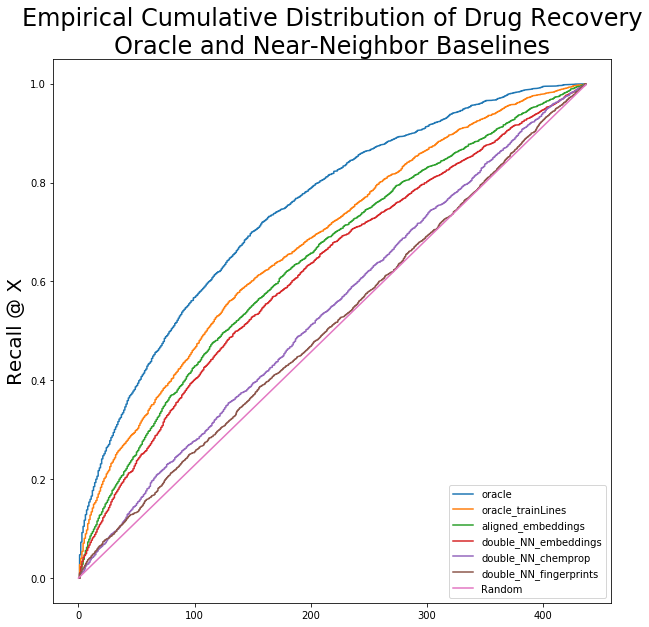

In [488]:
fig = plt.figure(figsize=(10,10))
cdf_plot(ranks_oracle_embedding, label = "oracle")
cdf_plot(ranks_oracle_embedding_trainLines, label = "oracle_trainLines")
#cdf_plot(ranks_oracle_embedding, label = "oracle_embed")
#cdf_plot(ranks_oracle_embedding_trainLines, label = "oracle_embed_trainLines")
#cdf_plot(ranks_oracle_geRaw, label = "oracle_raw")
#cdf_plot(ranks_oracle_rawGE_trainLines, label = "oracle_raw_trainLines")
cdf_plot(ranks_val_orig, label = "aligned_embeddings")
cdf_plot(ranks_chem_double_NN,  label = "double_NN_embeddings")
cdf_plot(ranks_chem_double_NN_chemprop,  label = "double_NN_chemprop")
cdf_plot(ranks_chem_double_NN_fps,  label = "double_NN_fingerprints")
cdf_plot(np.linspace(0, 437, 437), "Random")
plt.legend(loc="lower right")
plt.ylabel("Recall @ X", fontsize=20)
plt.title("Empirical Cumulative Distribution of Drug Recovery\nOracle and Near-Neighbor Baselines", fontsize=24)

#plt.savefig(FIG_SAVE_PATH + 'results_oracle_knn.png', bbox_inches='tight')
#plt.savefig(FIG_SAVE_PATH + 'results_oracle_knn.pdf', bbox_inches='tight')
plt.show()

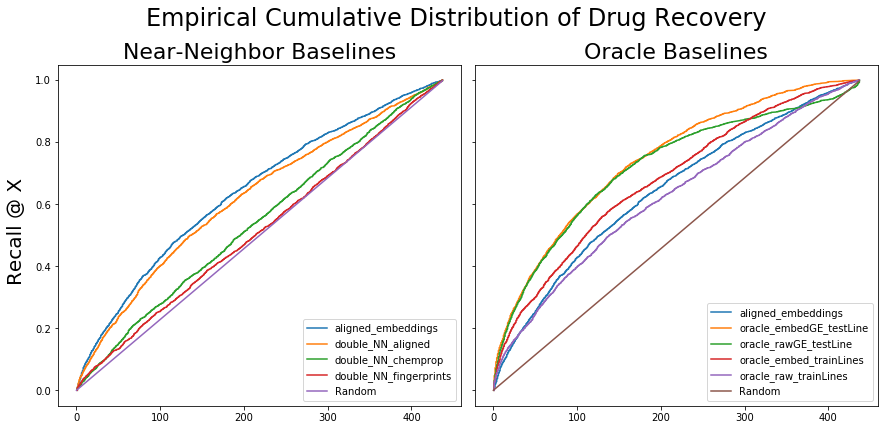

In [528]:
fig, (ax1, ax2) = plt.subplots(ncols=2, sharey=True, sharex=True)

def cdf_plot2(data, label, ax = None):
    ax.plot(np.sort(data), np.linspace(0, 1, len(data), endpoint=False), label = label)

fig.set_figwidth(12)
cdf_plot2(ranks_val_orig, label = "aligned_embeddings", ax = ax2)
cdf_plot2(ranks_oracle_embedding, label = "oracle_embedGE_testLine", ax = ax2)
cdf_plot2(ranks_oracle_geRaw, label = "oracle_rawGE_testLine", ax = ax2)
cdf_plot2(ranks_oracle_embedding_trainLines, label = "oracle_embed_trainLines", ax = ax2)
cdf_plot2(ranks_oracle_rawGE_trainLines, label = "oracle_raw_trainLines", ax = ax2)
cdf_plot2(np.linspace(0, 437, 437), "Random", ax = ax2)
ax2.legend(loc="lower right")
ax2.set(title="Oracle Baselines")
ax2.title.set_size(22)

cdf_plot2(ranks_val_orig, label = "aligned_embeddings", ax = ax1)
cdf_plot2(ranks_chem_double_NN,  label = "double_NN_aligned", ax = ax1)
cdf_plot2(ranks_chem_double_NN_chemprop,  label = "double_NN_chemprop", ax = ax1)
cdf_plot2(ranks_chem_double_NN_fps,  label = "double_NN_fingerprints", ax = ax1)
cdf_plot2(np.linspace(0, 437, 437), "Random", ax = ax1)
ax1.legend(loc="lower right")
ax1.set(title="Near-Neighbor Baselines")
ax1.title.set_size(22)

plt.tight_layout()
fig.set_figwidth(12)
fig.set_figheight(6)
fig.suptitle("Empirical Cumulative Distribution of Drug Recovery", fontsize=24, y = 1.02)
fig.text(-0.02, 0.5, 'Recall @ X', va='center', rotation='vertical', fontsize=20)

plt.savefig(FIG_SAVE_PATH + 'results_oracle_knn.png', bbox_inches='tight')
plt.savefig(FIG_SAVE_PATH + 'results_oracle_knn.pdf', bbox_inches='tight')
plt.show()

#### Double Nearest Neighbor, using Raw GEs for matching

In [465]:
print("Double Nearest Neighbors - GE/Embed")
#gex_raw_mean_train_pd2 = pd.DataFrame(data=gex_raw_train[:,978:1956], index = smiles_gex_labels_train ).rename_axis(index=['smiles']).groupby('smiles').mean()

gex_neighbors_in_train_rawGE = cdist(gex_raw[:,978:1956], gex_raw_mean_train_pd2,  metric='correlation')
#gex_neighbors_in_train_rawGE = cdist(ge_raw_pca, gex_raw_pca_mean_train_pd,  metric='correlation')
ind_nn_geRaw = np.argmin(gex_neighbors_in_train_rawGE, axis = 1)
gex_chem_double_NN_embed_rawGE_dist = dists_to_train_chem_embed.T[ind_nn_geRaw,:]
ranks_chem_double_NN_rawGE = get_val_scores(gex_chem_double_NN_embed_rawGE_dist)

Double Nearest Neighbors - GE/Embed
median_rank: 189.000    MRR: 0.033    H@10: 0.047    H@100: 0.290    H@500: 1.000


In [466]:
print("Double Nearest Neighbors - GE/Chemprop")
gex_chem_double_NN_chemprop_rawGE_dist = dists_to_train_chemprop.T[ind_nn_geRaw,:]
ranks_chem_double_NN_chemprop_rawGE = get_val_scores(gex_chem_double_NN_chemprop_rawGE_dist)


Double Nearest Neighbors - GE/Chemprop
median_rank: 211.000    MRR: 0.025    H@10: 0.035    H@100: 0.254    H@500: 1.000


In [467]:
print("Double Nearest Neighbors - GE/Fingerprints")
gex_chem_double_NN_fps_rawGE_dist = dists_to_train_fps.T[ind_nn_geRaw,:]
ranks_chem_double_NN_fps_rawGE = get_val_scores(gex_chem_double_NN_fps_rawGE_dist)


Double Nearest Neighbors - GE/Fingerprints
median_rank: 206.000    MRR: 0.025    H@10: 0.037    H@100: 0.240    H@500: 1.000


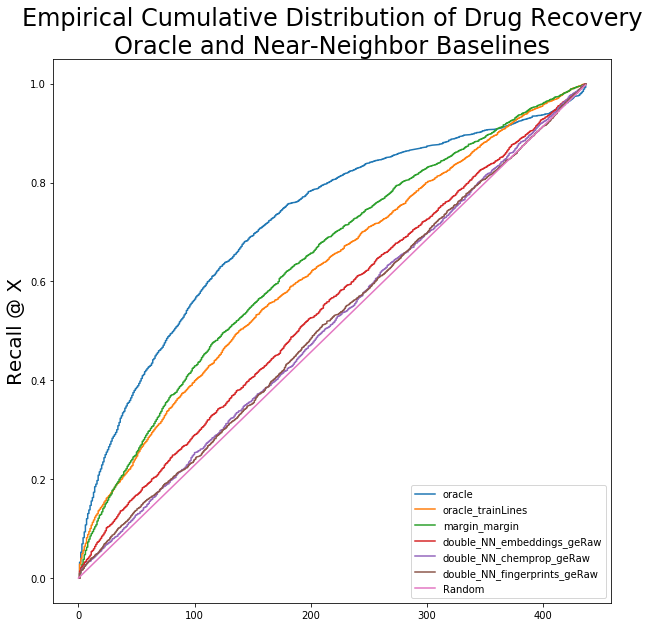

In [478]:
fig = plt.figure(figsize=(10,10))
cdf_plot(ranks_oracle_geRaw, label = "oracle")
cdf_plot(ranks_oracle_rawGE_trainLines, label = "oracle_trainLines")
cdf_plot(ranks_val_orig, label = "margin_margin")
cdf_plot(ranks_chem_double_NN_rawGE,  label = "double_NN_embeddings_geRaw")
cdf_plot(ranks_chem_double_NN_chemprop_rawGE,  label = "double_NN_chemprop_geRaw")
cdf_plot(ranks_chem_double_NN_fps_rawGE,  label = "double_NN_fingerprints_geRaw")
cdf_plot(np.linspace(0, 437, 437), "Random")
plt.legend(loc="lower right")
plt.ylabel("Recall @ X", fontsize=20)
plt.title("Empirical Cumulative Distribution of Drug Recovery\nOracle and Near-Neighbor Baselines", fontsize=24)
plt.show()

In [364]:
np.savez(NUMPY_RESULTS_PATH + 'results_drug_cell_split_baselines.npz',
         ranks_oracle_embedding, ranks_oracle_embedding_trainLines, ranks_val_orig,
         ranks_chem_double_NN, ranks_chem_double_NN_chemprop, ranks_chem_double_NN_fps,
         ranks_chem_double_NN_rawGE, ranks_chem_double_NN_chemprop_rawGE, ranks_chem_double_NN_fps_rawGE
        )
#import_npz(NUMPY_RESULTS_PATH + 'results_drug_cell_split_baselines.npz')

## Compute Results

In [63]:
gex_raw.shape, gex_embeddings.shape, chem_embeddings.shape, chem_embeddings_unique.shape, len(smiles_gex_labels), len(smiles_chem_labels)

((2317, 2934), (2317, 51), (2317, 51), (437, 51), 2317, 437)

In [67]:
print("Original")
gex_chem_baseline_dist = cdist(gex_embeddings, chem_embeddings_unique,  metric='correlation')
ranks_val_orig  = get_val_scores(gex_chem_baseline_dist)

Original
median_rank: 127.000    MRR: 0.039    H@10: 0.085    H@100: 0.429    H@500: 1.000


In [68]:
ranks_val_cca  = cca_cor()

CCA w/ 50 components
00:02:22.87
Computing Distances
median_rank: 130.000    MRR: 0.046    H@10: 0.091    H@100: 0.423    H@500: 1.000


In [69]:
ranks_val_geEmbed_fps_all = cca_cor(ncomp = 50,
                                     embeds_chem_train=fingerprints_train,
                                     embeds_chem_val=fingerprints,
                                     embeds_chem_uniq_val=fingerprints_unique)

CCA w/ 50 components
00:16:53.48
Computing Distances
median_rank: 155.000    MRR: 0.035    H@10: 0.066    H@100: 0.356    H@500: 1.000


In [70]:
ranks_val_rawGE_chemEmbed_all = cca_cor(ncomp = 50,
                                        embeds_ge_train=ge_raw_pca_train,
                                        embeds_ge_val=ge_raw_pca)

CCA w/ 50 components
00:18:24.04
Computing Distances
median_rank: 139.000    MRR: 0.044    H@10: 0.075    H@100: 0.407    H@500: 1.000


In [74]:
ranks_val_geEmbed_chemprop_all = cca_cor(ncomp = 50,
                                         embeds_chem_train=chemprop_embed_train_pca,
                                         embeds_chem_val=chemprop_embed_pca,
                                         embeds_chem_uniq_val=chem_embed_unique_chempropPCA)

CCA w/ 50 components
00:16:28.68
Computing Distances
median_rank: 166.000    MRR: 0.031    H@10: 0.059    H@100: 0.343    H@500: 1.000


In [75]:
ranks_val_rawGE_fps_all = cca_cor(ncomp = 50,
                                  embeds_ge_train=ge_raw_pca_train,
                                  embeds_chem_train=fingerprints_train,
                                  embeds_ge_val=ge_raw_pca,
                                  embeds_chem_val=fingerprints,
                                  embeds_chem_uniq_val=fingerprints_unique)

CCA w/ 50 components
00:33:06.48
Computing Distances
median_rank: 169.000    MRR: 0.040    H@10: 0.067    H@100: 0.347    H@500: 1.000


In [360]:
ranks_val_rawGE_chemprop_all = cca_cor(ncomp = 50,
                                       embeds_ge_train=ge_raw_pca_train,
                                       embeds_ge_val=ge_raw_pca,
                                       embeds_chem_train=chemprop_embed_train_pca,
                                       embeds_chem_val=chemprop_embed_pca,
                                       embeds_chem_uniq_val=chem_embed_unique_chempropPCA)

CCA w/ 50 components
00:16:25.98
Computing Distances
median_rank: 198.000    MRR: 0.027    H@10: 0.045    H@100: 0.293    H@500: 1.000


## Plots

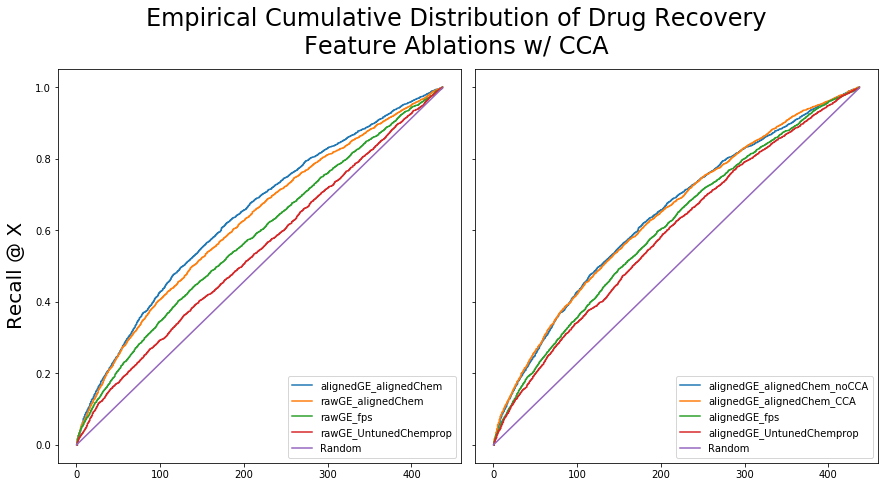

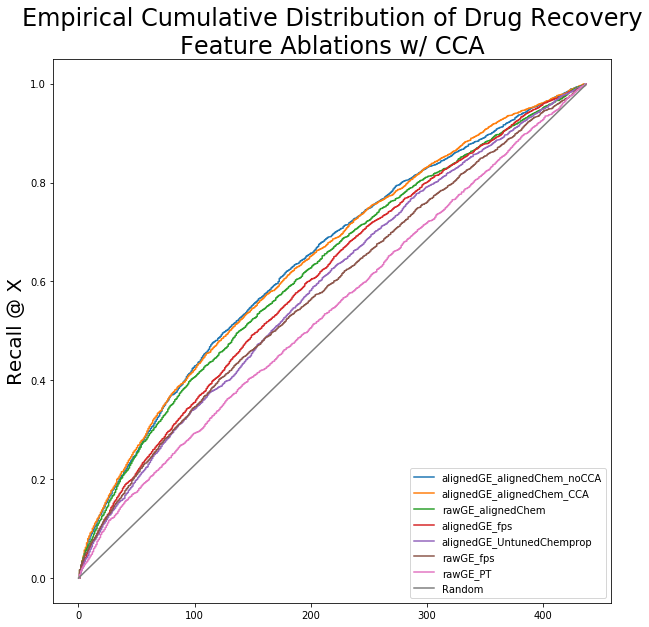

In [444]:
def cdf_plot2(data, label, ax = None):
    ax.plot(np.sort(data), np.linspace(0, 1, len(data), endpoint=False), label = label)

fig, (ax1, ax2) = plt.subplots(ncols=2, sharey=True, sharex=True)

cdf_plot2(ranks_val_orig, label = "alignedGE_alignedChem",ax =  ax1)
cdf_plot2(ranks_val_rawGE_chemEmbed_all, label = 'rawGE_alignedChem',ax =  ax1)
cdf_plot2(ranks_val_rawGE_fps_all, label = 'rawGE_fps',ax =  ax1)
cdf_plot2(ranks_val_rawGE_chemprop_all, label = 'rawGE_UntunedChemprop',ax =  ax1)
#cdf_plot(ranks_val_geEmbed_fps, label = "margin_fps",ax =  ax1)
#cdf_plot(ranks_val_geEmbed_chemprop_all, label = "margin_PT",ax =  ax1)
#cdf_plot(ranks_val_cca,  label = "margin_margin_CCA",ax =  ax1)
cdf_plot2(np.linspace(0, 437, 437), "Random",ax =  ax1)
ax1.legend(loc="lower right")

cdf_plot2(ranks_val_orig, label = "alignedGE_alignedChem_noCCA", ax = ax2)
cdf_plot2(ranks_val_cca,  label = "alignedGE_alignedChem_CCA", ax = ax2)
cdf_plot2(ranks_val_geEmbed_fps_all, label = "alignedGE_fps", ax = ax2)
cdf_plot2(ranks_val_geEmbed_chemprop_all, label = "alignedGE_UntunedChemprop", ax = ax2)
cdf_plot2(np.linspace(0, 437, 437), "Random", ax = ax2)
ax2.legend(loc="lower right")

fig.set_figwidth(12)
fig.set_figheight(6)
fig.suptitle("Empirical Cumulative Distribution of Drug Recovery\nFeature Ablations w/ CCA", fontsize=24, y = 1.12)
fig.text(-0.02, 0.5, 'Recall @ X', va='center', rotation='vertical', fontsize=20)

plt.tight_layout()
plt.savefig(FIG_SAVE_PATH + 'results_w_ablations.png', bbox_inches='tight')
plt.savefig(FIG_SAVE_PATH + 'results_w_ablations.pdf', bbox_inches='tight')
plt.show()



fig = plt.figure(figsize=(10,10))
cdf_plot(ranks_val_orig, label = "alignedGE_alignedChem_noCCA")
cdf_plot(ranks_val_cca,  label = "alignedGE_alignedChem_CCA")
cdf_plot(ranks_val_rawGE_chemEmbed_all, label = 'rawGE_alignedChem')
cdf_plot(ranks_val_geEmbed_fps_all, label = "alignedGE_fps")
cdf_plot(ranks_val_geEmbed_chemprop_all, label = "alignedGE_UntunedChemprop")
cdf_plot(ranks_val_rawGE_fps_all, label = 'rawGE_fps')
cdf_plot(ranks_val_rawGE_chemprop_all, label = 'rawGE_PT')
cdf_plot(np.linspace(0, 437, 437), "Random")
plt.legend(loc="lower right")
plt.ylabel("Recall @ X", fontsize=20)
plt.title("Empirical Cumulative Distribution of Drug Recovery\nFeature Ablations w/ CCA", fontsize=24)

plt.savefig(FIG_SAVE_PATH + 'results_w_ablations_all.png', bbox_inches='tight')
plt.savefig(FIG_SAVE_PATH + 'results_w_ablations_all.pdf', bbox_inches='tight')
plt.show()


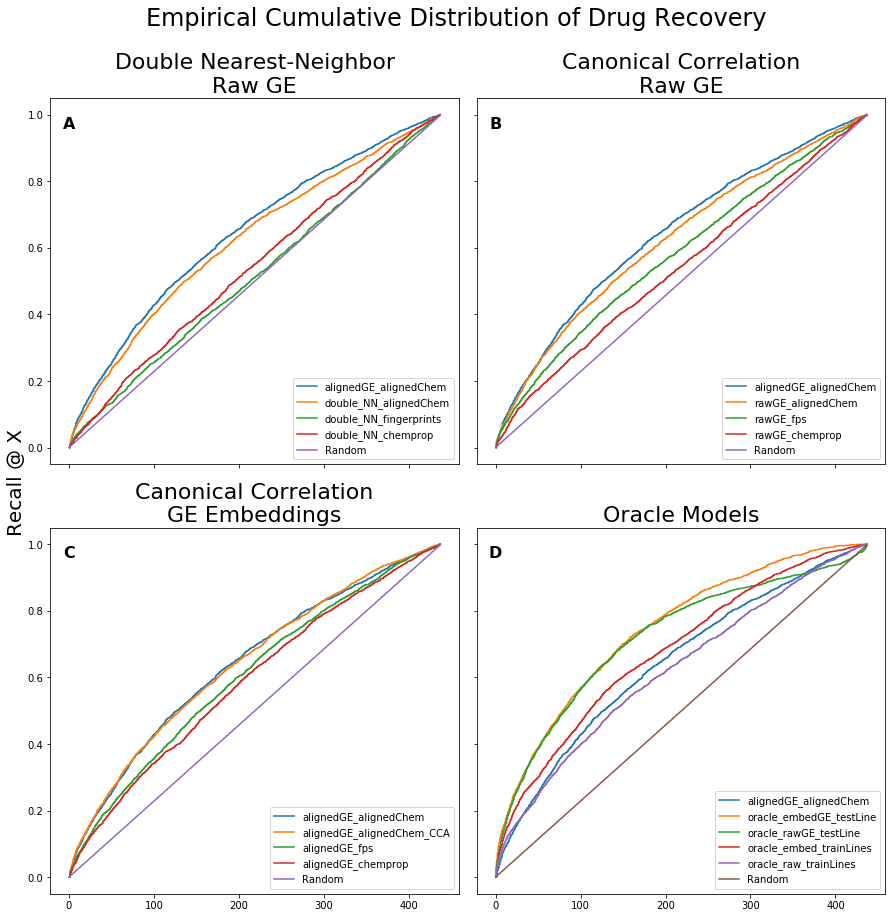

In [569]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(ncols=2, nrows=2, sharey=True, sharex=True, constrained_layout=True)

def cdf_plot2(data, label, ax = None):
    ax.plot(np.sort(data), np.linspace(0, 1, len(data), endpoint=False), label = label)

label_offsetx = 0.06
label_offsety = 0.95
    
cdf_plot2(ranks_val_orig, label = "alignedGE_alignedChem", ax = ax1)
cdf_plot2(ranks_chem_double_NN,  label = "double_NN_alignedChem", ax = ax1)
cdf_plot2(ranks_chem_double_NN_fps,  label = "double_NN_fingerprints", ax = ax1)
cdf_plot2(ranks_chem_double_NN_chemprop,  label = "double_NN_chemprop", ax = ax1)
cdf_plot2(np.linspace(0, 437, 437), "Random", ax = ax1)
ax1.legend(loc="lower right")
ax1.set(title="Double Nearest-Neighbor\nRaw GE")
ax1.title.set_size(22)
ax1.text(label_offsetx, label_offsety, "A", transform=ax1.transAxes,
      fontsize=16, fontweight='bold', va='top', ha='right')

cdf_plot2(ranks_val_orig, label = "alignedGE_alignedChem",ax =  ax2)
cdf_plot2(ranks_val_rawGE_chemEmbed_all, label = 'rawGE_alignedChem',ax =  ax2)
cdf_plot2(ranks_val_rawGE_fps_all, label = 'rawGE_fps',ax =  ax2)
cdf_plot2(ranks_val_rawGE_chemprop_all, label = 'rawGE_chemprop',ax =  ax2)
cdf_plot2(np.linspace(0, 437, 437), "Random",ax =  ax2)
ax2.set(title="Canonical Correlation\nRaw GE")
ax2.legend(loc="lower right")
ax2.title.set_size(22)
ax2.text(label_offsetx, label_offsety, "B", transform=ax2.transAxes,
      fontsize=16, fontweight='bold', va='top', ha='right')

cdf_plot2(ranks_val_orig, label = "alignedGE_alignedChem", ax = ax3)
cdf_plot2(ranks_val_cca,  label = "alignedGE_alignedChem_CCA", ax = ax3)
cdf_plot2(ranks_val_geEmbed_fps_all, label = "alignedGE_fps", ax = ax3)
cdf_plot2(ranks_val_geEmbed_chemprop_all, label = "alignedGE_chemprop", ax = ax3)
cdf_plot2(np.linspace(0, 437, 437), "Random", ax = ax3)
ax3.set(title="Canonical Correlation\nGE Embeddings")
ax3.legend(loc="lower right")
ax3.title.set_size(22)
ax3.text(label_offsetx, label_offsety, "C", transform=ax3.transAxes,
      fontsize=16, fontweight='bold', va='top', ha='right')

cdf_plot2(ranks_val_orig, label = "alignedGE_alignedChem", ax = ax4)
cdf_plot2(ranks_oracle_embedding, label = "oracle_embedGE_testLine", ax = ax4)
cdf_plot2(ranks_oracle_geRaw, label = "oracle_rawGE_testLine", ax = ax4)
cdf_plot2(ranks_oracle_embedding_trainLines, label = "oracle_embed_trainLines", ax = ax4)
cdf_plot2(ranks_oracle_rawGE_trainLines, label = "oracle_raw_trainLines", ax = ax4)
cdf_plot2(np.linspace(0, 437, 437), "Random", ax = ax4)
ax4.legend(loc="lower right")
ax4.set(title="Oracle Models")
ax4.title.set_size(22)
ax4.text(label_offsetx, label_offsety, "D", transform=ax4.transAxes,
      fontsize=16, fontweight='bold', va='top', ha='right')

#plt.tight_layout()
fig.set_figwidth(12)
fig.set_figheight(12)
fig.suptitle("Empirical Cumulative Distribution of Drug Recovery", fontsize=24, y = 1.05)
fig.text(-0.02, 0.5, 'Recall @ X', va='center', rotation='vertical', fontsize=20)

plt.savefig(FIG_SAVE_PATH + 'ecdf_all.png', bbox_inches='tight')
plt.savefig(FIG_SAVE_PATH + 'ecdf_all.pdf', bbox_inches='tight')
plt.show()

## Save results


In [365]:
np.savez(NUMPY_RESULTS_PATH + 'results_drug_cell_split.npz',
         ranks_val_orig, ranks_val_cca, ranks_val_geEmbed_chemprop_all, ranks_val_geEmbed_fps_all,
         ranks_val_rawGE_chemEmbed_all, ranks_val_rawGE_chemprop_all, ranks_val_rawGE_fps_all
        )
#import_npz(NUMPY_RESULTS_PATH + 'results_drug_cell_split.npz')

# Analyze Results

In [143]:
### Number of significant genes -- relevant to both

In [144]:
from collections import Counter
counts_gex_smiles = Counter(smiles_gex_labels)

In [145]:
import pandas as pd
ranks_pd = pd.DataFrame(ranks_val_orig, index = smiles_gex_labels)

recip_ranks_pd = 1 / ranks_pd
MRR_by_smiles_pd = recip_ranks_pd.groupby(recip_ranks_pd.index).mean()
MRR_by_smiles_pd = MRR_by_smiles_pd.loc[smiles_chem_labels]

MR_by_smiles_pd = ranks_pd.groupby(ranks_pd.index).median()
MR_by_smiles_pd = MR_by_smiles_pd.loc[smiles_chem_labels]

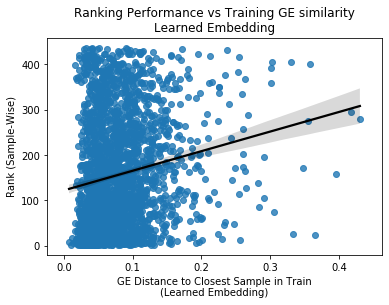

LinregressResult(slope=431.51345418503945, intercept=122.35905220691555, rvalue=0.16614950051847197, pvalue=8.324449233060577e-16, stderr=53.228106280965854)

In [773]:
import seaborn as sns
ax = sns.regplot(x = min_dists_to_train_ge_embed, y=ranks_pd.values,
                line_kws={'color':'black'})
ax.set(ylabel='Rank (Sample-Wise)', xlabel='GE Distance to Closest Sample in Train\n(Learned Embedding)',
      title="Ranking Performance vs Training GE similarity\nLearned Embedding")
plt.savefig(FIG_SAVE_PATH + 'rankings_v_trainSim_geEmbed.png', bbox_inches='tight')
plt.savefig(FIG_SAVE_PATH + 'rankings_v_trainSim_geEmbed.pdf', bbox_inches='tight')
plt.show()
stats.linregress(min_dists_to_train_ge_embed.squeeze(), ranks_pd.values.squeeze())

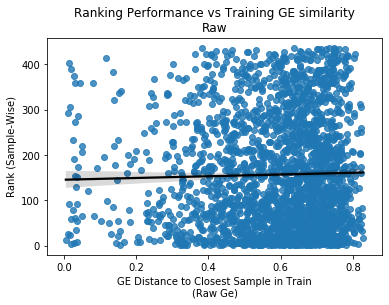

LinregressResult(slope=19.11898270562999, intercept=145.68808450194493, rvalue=0.023972875594202026, pvalue=0.24871225088877386, stderr=16.570832250829586)

In [774]:
import seaborn as sns
ax = sns.regplot(y = ranks_pd.values, x=min_dists_to_train_ge_raw,
                line_kws={'color':'black'})
ax.set(ylabel='Rank (Sample-Wise)', xlabel='GE Distance to Closest Sample in Train\n(Raw Ge)',
      title="Ranking Performance vs Training GE similarity\nRaw")
plt.savefig(FIG_SAVE_PATH + 'rankings_v_trainSim_geRaw.png', bbox_inches='tight')
plt.savefig(FIG_SAVE_PATH + 'rankings_v_trainSim_geRaw.pdf', bbox_inches='tight')
plt.show()
stats.linregress(min_dists_to_train_ge_raw.squeeze(), ranks_pd.values.squeeze())

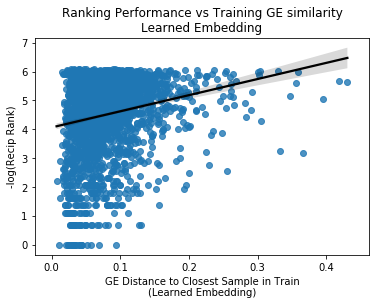

LinregressResult(slope=5.587627127069089, intercept=4.065497513446732, rvalue=0.2043892756437139, pvalue=2.841858135529017e-23, stderr=0.5561956258141859)

In [775]:
ax = sns.regplot(x = min_dists_to_train_ge_embed, y=-np.log(recip_ranks_pd.values),
                line_kws={'color':'black'})
ax.set(ylabel='-log(Recip Rank)', xlabel='GE Distance to Closest Sample in Train\n(Learned Embedding)',
      title="Ranking Performance vs Training GE similarity\nLearned Embedding")
plt.savefig(FIG_SAVE_PATH + 'MRR_v_trainSim_geEmbed.png', bbox_inches='tight')
plt.savefig(FIG_SAVE_PATH + 'MRR_v_trainSim_geEmbed.pdf', bbox_inches='tight')
plt.show()
stats.linregress(min_dists_to_train_ge_embed.squeeze(), -np.log(recip_ranks_pd.values).squeeze())

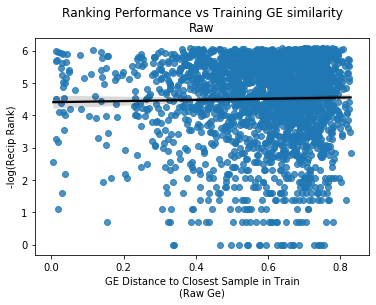

LinregressResult(slope=0.17795141761349823, intercept=4.408512474441655, rvalue=0.021197409603785494, pvalue=0.3077730001176216, stderr=0.17443979586035774)

In [776]:
ax = sns.regplot(y = -np.log(recip_ranks_pd.values), x=min_dists_to_train_ge_raw,
                line_kws={'color':'black'})
ax.set(ylabel='-log(Recip Rank)', xlabel='GE Distance to Closest Sample in Train\n(Raw Ge)',
      title="Ranking Performance vs Training GE similarity\nRaw")
plt.savefig(FIG_SAVE_PATH + 'MRR_v_trainSim_geRaw.png', bbox_inches='tight')
plt.savefig(FIG_SAVE_PATH + 'MRR_v_trainSim_geRaw.pdf', bbox_inches='tight')
plt.show()
stats.linregress(min_dists_to_train_ge_raw.squeeze(), -np.log(recip_ranks_pd.values).squeeze())

In [148]:
### For Cell line only split, the following should be against the number of times the drug appears in the train set

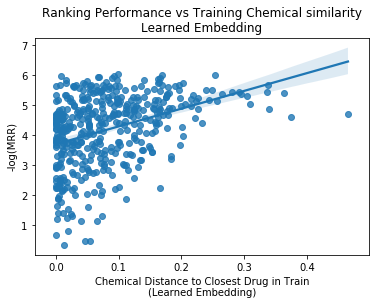

LinregressResult(slope=5.920638048802703, intercept=3.707345618401156, rvalue=0.37099016932693096, pvalue=1.0471892531987457e-15, stderr=0.7105708193346254)

In [777]:
import seaborn as sns
ax = sns.regplot(y = -np.log(MRR_by_smiles_pd.values), x=min_dists_to_train_chem_embed)
ax.set(ylabel='-log(MRR)', xlabel='Chemical Distance to Closest Drug in Train\n(Learned Embedding)',
      title="Ranking Performance vs Training Chemical similarity\nLearned Embedding")
plt.savefig(FIG_SAVE_PATH + 'rankings_v_trainSim_chemEmbed.png', bbox_inches='tight')
plt.savefig(FIG_SAVE_PATH + 'rankings_v_trainSim_chemEmbed.pdf', bbox_inches='tight')
plt.show()
stats.linregress(min_dists_to_train_chem_embed.squeeze(), -np.log(MRR_by_smiles_pd.values).squeeze())

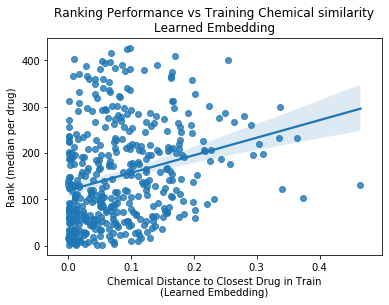

LinregressResult(slope=378.64163621018565, intercept=119.34359290806148, rvalue=0.263884183776242, pvalue=2.141704326464208e-08, stderr=66.35858133659015)

In [778]:
ax = sns.regplot(y = MR_by_smiles_pd.values, x=min_dists_to_train_chem_embed)
ax.set(ylabel='Rank (median per drug)', xlabel='Chemical Distance to Closest Drug in Train\n(Learned Embedding)',
             title="Ranking Performance vs Training Chemical similarity\nLearned Embedding")
plt.savefig(FIG_SAVE_PATH + 'rankings_v_trainSim_chemEmbed_median.png', bbox_inches='tight')
plt.savefig(FIG_SAVE_PATH + 'rankings_v_trainSim_chemEmbed_median.pdf', bbox_inches='tight')
plt.show()
stats.linregress(min_dists_to_train_chem_embed.squeeze(), MR_by_smiles_pd.squeeze())

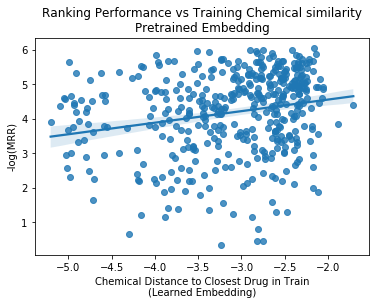

LinregressResult(slope=0.3355642314518973, intercept=5.2341215435786195, rvalue=0.21559346533733914, pvalue=5.427065480716837e-06, stderr=0.0728719213613285)

In [779]:
ax = sns.regplot(y = -np.log(MRR_by_smiles_pd.values), x=np.log(min_dists_to_train_chemprop))
ax.set(ylabel='-log(MRR)', xlabel='Chemical Distance to Closest Drug in Train\n(Learned Embedding)',
             title="Ranking Performance vs Training Chemical similarity\nPretrained Embedding")
plt.savefig(FIG_SAVE_PATH + 'rankings_v_trainSim_chemprop.png', bbox_inches='tight')
plt.savefig(FIG_SAVE_PATH + 'rankings_v_trainSim_chemprop.pdf', bbox_inches='tight')
plt.show()
stats.linregress(np.log(min_dists_to_train_chemprop).squeeze(), -np.log(MRR_by_smiles_pd.values).squeeze())

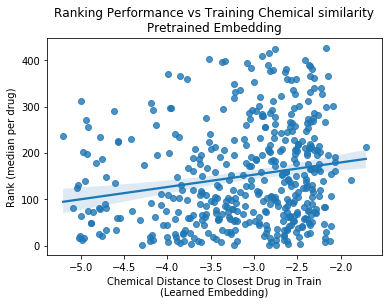

LinregressResult(slope=26.449780072118237, intercept=232.49115284327945, rvalue=0.18900491557944601, pvalue=7.01918597576981e-05, stderr=6.588784047687085)

In [780]:
ax = sns.regplot(y = MR_by_smiles_pd.values, x=np.log(min_dists_to_train_chemprop))
ax.set(ylabel='Rank (median per drug)', xlabel='Chemical Distance to Closest Drug in Train\n(Learned Embedding)',
             title="Ranking Performance vs Training Chemical similarity\nPretrained Embedding")
plt.savefig(FIG_SAVE_PATH + 'rankings_v_trainSim_chemprop_median.png', bbox_inches='tight')
plt.savefig(FIG_SAVE_PATH + 'rankings_v_trainSim_chemprop_median.pdf', bbox_inches='tight')
plt.show()
stats.linregress(np.log(min_dists_to_train_chemprop).squeeze(), MR_by_smiles_pd.values.squeeze())

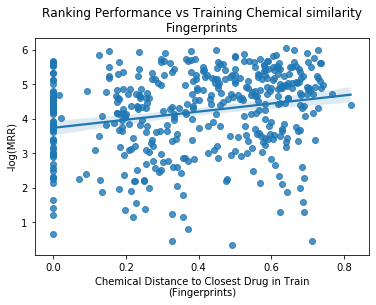

LinregressResult(slope=1.1730941341212489, intercept=3.7444373933234343, rvalue=0.22687380384786682, pvalue=1.6534647975065702e-06, stderr=0.24145100824766597)

In [781]:
ax = sns.regplot(y = -np.log(MRR_by_smiles_pd.values), x=min_dists_to_train_fps)
ax.set(ylabel='-log(MRR)', xlabel='Chemical Distance to Closest Drug in Train\n(Fingerprints)',
             title="Ranking Performance vs Training Chemical similarity\nFingerprints")
plt.savefig(FIG_SAVE_PATH + 'rankings_v_trainSim_fps.png', bbox_inches='tight')
plt.savefig(FIG_SAVE_PATH + 'rankings_v_trainSim_fps.pdf', bbox_inches='tight')
plt.show()
stats.linregress(min_dists_to_train_fps.squeeze(), -np.log(MRR_by_smiles_pd.values).squeeze())

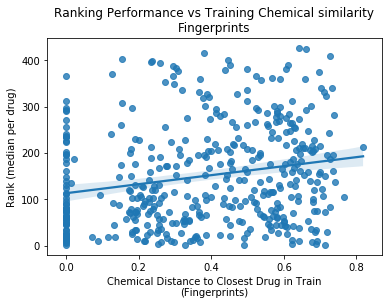

LinregressResult(slope=97.23024912928872, intercept=113.25655587170253, rvalue=0.20914331672528072, pvalue=1.0415186359595163e-05, stderr=21.79719268855879)

In [782]:
ax = sns.regplot(y = MR_by_smiles_pd.values, x=min_dists_to_train_fps)
ax.set(ylabel='Rank (median per drug)', xlabel='Chemical Distance to Closest Drug in Train\n(Fingerprints)',
             title="Ranking Performance vs Training Chemical similarity\nFingerprints")
plt.savefig(FIG_SAVE_PATH + 'rankings_v_trainSim_fps_median.png', bbox_inches='tight')
plt.savefig(FIG_SAVE_PATH + 'rankings_v_trainSim_fps_median.pdf', bbox_inches='tight')
plt.show()
stats.linregress(min_dists_to_train_fps.squeeze(), MR_by_smiles_pd.values.squeeze())

## Gene Counts

In [160]:
pertid_gene_counts = pd.read_csv("/home/sgf2/DBMI_server/drug_repo/data/pert_id_gene_counts.tsv", sep = "\t")
pertid_to_geneCounts = dict(zip(pertid_gene_counts.pert_id.values, pertid_gene_counts.mean_sig_genes.values))

all_smiles = np.append(val_dataset.l1000_perts.index.get_level_values("canonical_smiles").values,
                                     train_dataset.l1000_perts.index.get_level_values("canonical_smiles").values)
all_pertids = np.append(val_dataset.l1000_perts.index.get_level_values("pert_id").values,
                                     train_dataset.l1000_perts.index.get_level_values("pert_id").values)

smiles_to_perts = dict(zip(all_smiles, all_pertids))

smiles_to_gene_counts = {smile:pertid_to_geneCounts[smiles_to_perts[smile]] for smile in all_smiles if smiles_to_perts[smile] in pertid_to_geneCounts}


chem_inds_w_counts = [ind for ind in range(len(smiles_chem_labels)) if smiles_chem_labels[ind] in smiles_to_gene_counts]
chem_gene_counts = [smiles_to_gene_counts[smiles_chem_labels[ind]] for ind in chem_inds_w_counts]

chem_inds_w_counts_train = [ind for ind in range(len(smiles_chem_labels_train)) if smiles_chem_labels_train[ind] in smiles_to_gene_counts]
chem_gene_counts_train = [smiles_to_gene_counts[smiles_chem_labels_train[ind]] for ind in chem_inds_w_counts_train]

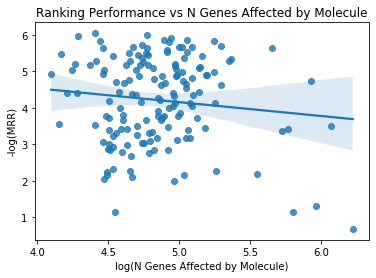

LinregressResult(slope=-0.37842650414900114, intercept=6.046276183100418, rvalue=-0.11820465448734128, pvalue=0.14560637066730264, stderr=0.25870394011674547)

In [783]:
import seaborn as sns
ax = sns.regplot(y = -np.log(MRR_by_smiles_pd.values[chem_inds_w_counts]), x=np.log(chem_gene_counts))
ax.set(ylabel='-log(MRR)', xlabel='log(N Genes Affected by Molecule)',
      title="Ranking Performance vs N Genes Affected by Molecule")
plt.savefig(FIG_SAVE_PATH + 'rankings_v_geneCount.png', bbox_inches='tight')
plt.savefig(FIG_SAVE_PATH + 'rankings_v_geneCount.pdf', bbox_inches='tight')
plt.show()
stats.linregress(np.log(chem_gene_counts).squeeze(), -np.log(MRR_by_smiles_pd.values[chem_inds_w_counts]).squeeze())

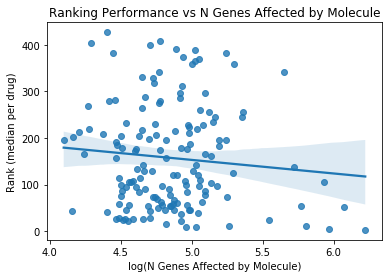

LinregressResult(slope=-29.137828352056538, intercept=298.5528843965236, rvalue=-0.09672376863971846, pvalue=0.23428765466070406, stderr=24.400257890219724)

In [784]:
ax = sns.regplot(y = MR_by_smiles_pd.values[chem_inds_w_counts], x=np.log(chem_gene_counts))
ax.set(ylabel='Rank (median per drug)',  xlabel='log(N Genes Affected by Molecule)',
             title="Ranking Performance vs N Genes Affected by Molecule")
plt.savefig(FIG_SAVE_PATH + 'rankings_v_geneCount_median.png', bbox_inches='tight')
plt.savefig(FIG_SAVE_PATH + 'rankings_v_geneCount_median.pdf', bbox_inches='tight')
plt.show()
stats.linregress(np.log(chem_gene_counts).squeeze(), MR_by_smiles_pd.values[chem_inds_w_counts].squeeze())

LinregressResult(slope=0.3355642314518973, intercept=5.2341215435786195, rvalue=0.21559346533733914, pvalue=5.427065480716837e-06, stderr=0.0728719213613285)
LinregressResult(slope=-0.37842650414900114, intercept=6.046276183100418, rvalue=-0.11820465448734128, pvalue=0.14560637066730264, stderr=0.25870394011674547)


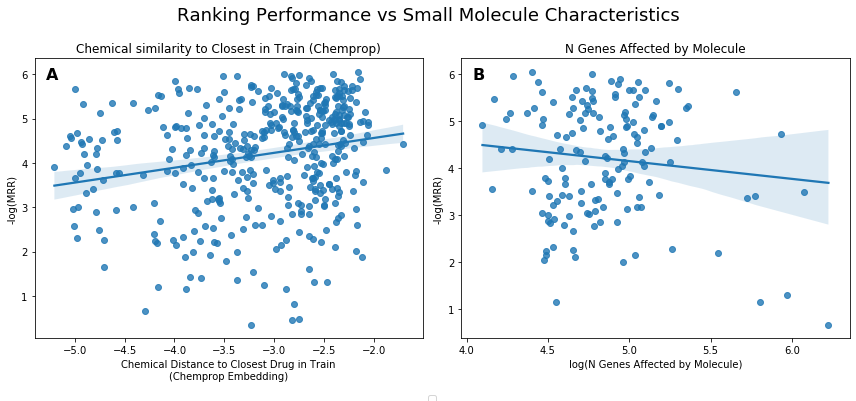

In [795]:
fig, (ax1, ax2) = plt.subplots(ncols=2)

label_offsetx = 0.06
label_offsety = 0.97
title_size = 16

sns.regplot(y = -np.log(MRR_by_smiles_pd.values), x=np.log(min_dists_to_train_chemprop), ax = ax1)
ax1.set(ylabel='-log(MRR)', xlabel='Chemical Distance to Closest Drug in Train\n(Chemprop Embedding)',
             title="Chemical similarity to Closest in Train (Chemprop)")
print(stats.linregress(np.log(min_dists_to_train_chemprop).squeeze(), -np.log(MRR_by_smiles_pd.values).squeeze()))

sns.regplot(y = -np.log(MRR_by_smiles_pd.values[chem_inds_w_counts]), x=np.log(chem_gene_counts), ax = ax2)
ax2.set(ylabel='-log(MRR)',  xlabel='log(N Genes Affected by Molecule)',
             title="N Genes Affected by Molecule")
print(stats.linregress(np.log(chem_gene_counts).squeeze(), -np.log(MRR_by_smiles_pd.values[chem_inds_w_counts]).squeeze()))

#sns.regplot(y = -np.log(MRR_by_smiles_pd.values), x=min_dists_to_train_fps, ax = ax1)
#ax1.set(ylabel='-log(MRR)', xlabel='Chemical Distance to Closest Drug in Train\n(Fingerprints)',
#             title="Ranking Performance vs Training Chemical similarity\nFingerprints")

fig.set_figwidth(12)
fig.set_figheight(5)

fig.suptitle("Ranking Performance vs Small Molecule Characteristics", fontsize=18, y = 1.07)
handles, labels = ax2.get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center', bbox_to_anchor=(0.5,-0.02), ncol = 3)
plt.tight_layout()

ax1.text(label_offsetx, label_offsety, "A", transform=ax1.transAxes,
      fontsize=16, fontweight='bold', va='top', ha='right')
ax2.text(label_offsetx, label_offsety, "B", transform=ax2.transAxes,
      fontsize=16, fontweight='bold', va='top', ha='right')

plt.savefig(FIG_SAVE_PATH + 'performance_predictors.png', bbox_inches='tight')
plt.savefig(FIG_SAVE_PATH + 'performance_predictors.pdf', bbox_inches='tight')
plt.show()

LinregressResult(slope=1.1730941341212489, intercept=3.7444373933234343, rvalue=0.22687380384786682, pvalue=1.6534647975065702e-06, stderr=0.24145100824766597)
LinregressResult(slope=5.920638048802703, intercept=3.707345618401156, rvalue=0.37099016932693096, pvalue=1.0471892531987457e-15, stderr=0.7105708193346254)
LinregressResult(slope=0.17795141761349823, intercept=4.408512474441655, rvalue=0.021197409603785494, pvalue=0.3077730001176216, stderr=0.17443979586035774)
LinregressResult(slope=5.587627127069089, intercept=4.065497513446732, rvalue=0.2043892756437139, pvalue=2.841858135529017e-23, stderr=0.5561956258141859)


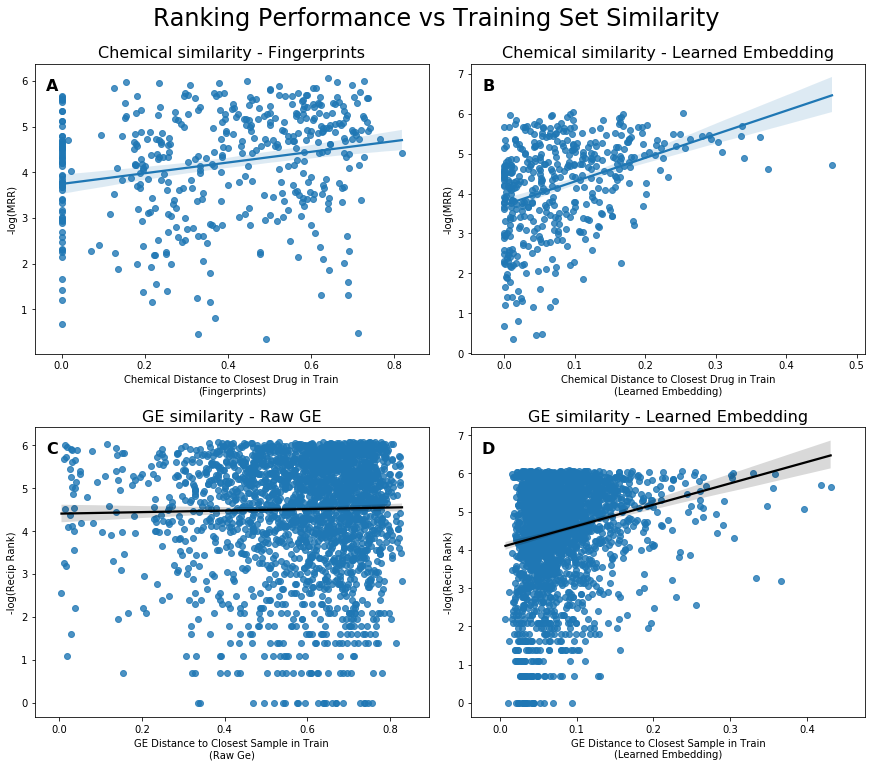

In [788]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(ncols=2, nrows=2, sharey=False, sharex=False, constrained_layout=True)

label_offsetx = 0.06
label_offsety = 0.95
title_size = 16

sns.regplot(y = -np.log(MRR_by_smiles_pd.values), x=min_dists_to_train_fps, ax = ax1)
ax1.set(ylabel='-log(MRR)', xlabel='Chemical Distance to Closest Drug in Train\n(Fingerprints)',
             title="Chemical similarity - Fingerprints")
ax1.title.set_size(title_size)
print(stats.linregress(min_dists_to_train_fps.squeeze(), -np.log(MRR_by_smiles_pd.values).squeeze()))


sns.regplot(y = -np.log(MRR_by_smiles_pd.values), x=min_dists_to_train_chem_embed, ax = ax2)
ax2.set(ylabel='-log(MRR)', xlabel='Chemical Distance to Closest Drug in Train\n(Learned Embedding)',
      title="Chemical similarity - Learned Embedding")
ax2.title.set_size(title_size)
print(stats.linregress(min_dists_to_train_chem_embed.squeeze(), -np.log(MRR_by_smiles_pd.values).squeeze()))


sns.regplot(y = -np.log(recip_ranks_pd.values), x=min_dists_to_train_ge_raw,
                line_kws={'color':'black'}, ax = ax3)
ax3.set(ylabel='-log(Recip Rank)', xlabel='GE Distance to Closest Sample in Train\n(Raw Ge)',
      title="GE similarity - Raw GE")
ax3.title.set_size(title_size)
print(stats.linregress(min_dists_to_train_ge_raw.squeeze(), -np.log(recip_ranks_pd.values).squeeze()))


sns.regplot(x = min_dists_to_train_ge_embed, y=-np.log(recip_ranks_pd.values),
                line_kws={'color':'black'}, ax = ax4)
ax4.set(ylabel='-log(Recip Rank)', xlabel='GE Distance to Closest Sample in Train\n(Learned Embedding)',
      title="GE similarity - Learned Embedding")
ax4.title.set_size(title_size)
print(stats.linregress(min_dists_to_train_ge_embed.squeeze(), -np.log(recip_ranks_pd.values).squeeze()))


ax1.text(label_offsetx, label_offsety, "A", transform=ax1.transAxes,
      fontsize=16, fontweight='bold', va='top', ha='right')
ax2.text(label_offsetx, label_offsety, "B", transform=ax2.transAxes,
      fontsize=16, fontweight='bold', va='top', ha='right')
ax3.text(label_offsetx, label_offsety, "C", transform=ax3.transAxes,
      fontsize=16, fontweight='bold', va='top', ha='right')
ax4.text(label_offsetx, label_offsety, "D", transform=ax4.transAxes,
      fontsize=16, fontweight='bold', va='top', ha='right')

fig.set_figwidth(12)
fig.set_figheight(10)
fig.suptitle("Ranking Performance vs Training Set Similarity", fontsize=24, y = 1.05)

plt.savefig(FIG_SAVE_PATH + 'performance_predictors_append.png', bbox_inches='tight')
plt.savefig(FIG_SAVE_PATH + 'performance_predictors_append.pdf', bbox_inches='tight')

plt.show()

LinregressResult(slope=0.3355642314518973, intercept=5.2341215435786195, rvalue=0.21559346533733914, pvalue=5.427065480716837e-06, stderr=0.0728719213613285)
LinregressResult(slope=-0.003505975262097554, intercept=4.694943493630996, rvalue=-0.1959292688789669, pvalue=0.015215453791359626, stderr=0.0014279760718096928)


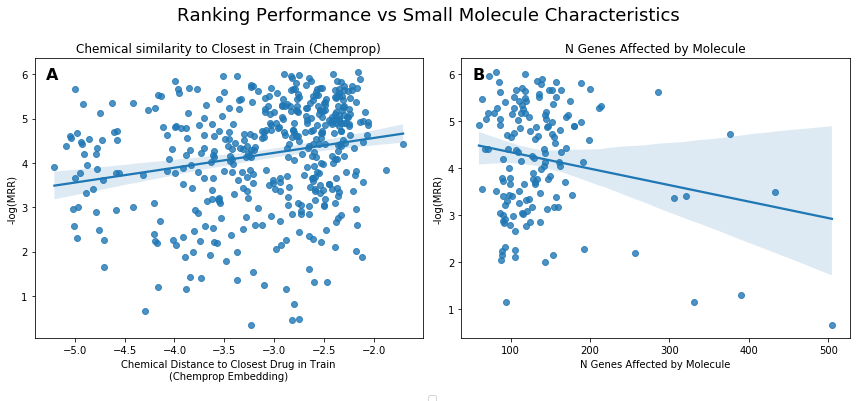

In [798]:
fig, (ax1, ax2) = plt.subplots(ncols=2)

label_offsetx = 0.06
label_offsety = 0.97
title_size = 16

sns.regplot(y = -np.log(MRR_by_smiles_pd.values), x=np.log(min_dists_to_train_chemprop), ax = ax1)
ax1.set(ylabel='-log(MRR)', xlabel='Chemical Distance to Closest Drug in Train\n(Chemprop Embedding)',
             title="Chemical similarity to Closest in Train (Chemprop)")
print(stats.linregress(np.log(min_dists_to_train_chemprop).squeeze(), -np.log(MRR_by_smiles_pd.values).squeeze()))

sns.regplot(y = -np.log(MRR_by_smiles_pd.values[chem_inds_w_counts]), x=chem_gene_counts, ax = ax2)
ax2.set(ylabel='-log(MRR)',  xlabel='N Genes Affected by Molecule',
             title="N Genes Affected by Molecule")
print(stats.linregress(np.array(chem_gene_counts).squeeze(), -np.log(MRR_by_smiles_pd.values[chem_inds_w_counts]).squeeze()))

#sns.regplot(y = -np.log(MRR_by_smiles_pd.values), x=min_dists_to_train_fps, ax = ax1)
#ax1.set(ylabel='-log(MRR)', xlabel='Chemical Distance to Closest Drug in Train\n(Fingerprints)',
#             title="Ranking Performance vs Training Chemical similarity\nFingerprints")

fig.set_figwidth(12)
fig.set_figheight(5)

fig.suptitle("Ranking Performance vs Small Molecule Characteristics", fontsize=18, y = 1.07)
handles, labels = ax2.get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center', bbox_to_anchor=(0.5,-0.02), ncol = 3)
plt.tight_layout()

ax1.text(label_offsetx, label_offsety, "A", transform=ax1.transAxes,
      fontsize=16, fontweight='bold', va='top', ha='right')
ax2.text(label_offsetx, label_offsety, "B", transform=ax2.transAxes,
      fontsize=16, fontweight='bold', va='top', ha='right')

plt.savefig(FIG_SAVE_PATH + 'performance_predictors_nolog.png', bbox_inches='tight')
plt.savefig(FIG_SAVE_PATH + 'performance_predictors_nolog.pdf', bbox_inches='tight')
plt.show()

## Chem GE Corr

In [156]:
ge_chem_corrs = gex_embeddings_mean_pd.corrwith(chem_embeddings_mean_pd, axis = "columns")
ge_chem_corrs.shape

(437,)

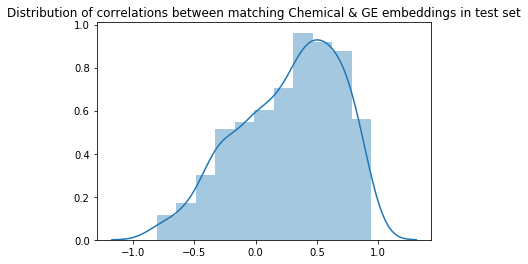

In [407]:
sns.distplot(ge_chem_corrs)
plt.title("Distribution of correlations between matching Chemical & GE embeddings in test set")
plt.savefig(FIG_SAVE_PATH + 'distEmbedCorrs.png', bbox_inches='tight')
plt.savefig(FIG_SAVE_PATH + 'distEmbedCorrs.pdf', bbox_inches='tight')
plt.show()

In [797]:
np.mean(ge_chem_corrs), np.min(ge_chem_corrs), np.max(ge_chem_corrs), np.std(ge_chem_corrs)

(0.27032271365356997,
 -0.8082913800333766,
 0.9446612243851124,
 0.41076321309472363)

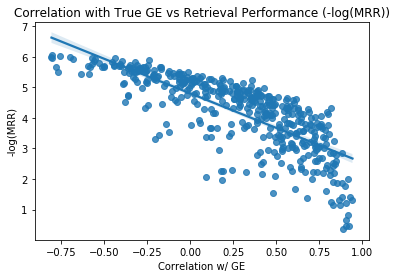

In [396]:
ax = sns.regplot(y = -np.log(MRR_by_smiles_pd.values), x=ge_chem_corrs)
ax.set(xlabel='Correlation w/ GE', ylabel='-log(MRR)',
             title="Correlation with True GE vs Retrieval Performance (-log(MRR))")
plt.savefig(FIG_SAVE_PATH + 'rankings_v_embedCorrs.png', bbox_inches='tight')
plt.savefig(FIG_SAVE_PATH + 'rankings_v_embedCorrs.pdf', bbox_inches='tight')
plt.show()

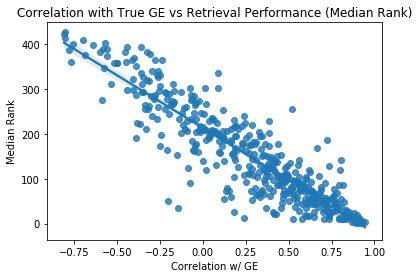

In [397]:
ax = sns.regplot(y = MR_by_smiles_pd.values, x=ge_chem_corrs)
ax.set(xlabel='Correlation w/ GE', ylabel='Median Rank',
             title="Correlation with True GE vs Retrieval Performance (Median Rank)")
plt.savefig(FIG_SAVE_PATH + 'rankings_v_embedCorrs_median.png', bbox_inches='tight')
plt.savefig(FIG_SAVE_PATH + 'rankings_v_embedCorrs_median.pdf', bbox_inches='tight')
plt.show()